In [56]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nfl-big-data-bowl-2026-prediction/test_input.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/test.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/nfl_inference_server.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/nfl_gateway.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/__init__.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/templates.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/base_gateway.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/relay.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/kaggle_evaluation.proto
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/__init__.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/generated/kaggle_evaluation_pb2.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/generated/kaggle_evaluati

In [57]:
!pip install pytorch-tabnet optuna


In [58]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,GroupShuffleSplit,KFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import warnings
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from datetime import datetime
from scipy.stats import skew, kurtosis
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import optuna
import joblib
import random
from glob import glob
from tqdm.auto import tqdm
warnings.filterwarnings("ignore")

# torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# TabNet
from pytorch_tabnet.tab_model import TabNetRegressor



In [59]:
# ============================================================================
# GPU CONFIGURATION & OPTIMIZATION
# ============================================================================

def setup_gpu():
    """Configure GPU for optimal performance"""
    print("="*80)
    print("GPU CONFIGURATION")
    print("="*80)
    
    # Check available GPUs
    gpus = tf.config.list_physical_devices('GPU')
    print(f"\n🖥️  Available GPUs: {len(gpus)}")
    
    if gpus:
        try:
            # Enable memory growth (don't allocate all GPU memory at once)
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                print(f"   ✓ GPU: {gpu.name} - Memory growth enabled")
            
            # Set GPU memory limit (optional - useful if sharing GPU)
            # tf.config.set_logical_device_configuration(
            #     gpus[0],
            #     [tf.config.LogicalDeviceConfiguration(memory_limit=4096)]  # 4GB
            # )
            
            # Use mixed precision for faster training
            policy = tf.keras.mixed_precision.Policy('mixed_float16')
            tf.keras.mixed_precision.set_global_policy(policy)
            print(f"   ✓ Mixed precision enabled: {policy.name}")
            
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(f"   ✓ Logical GPUs: {len(logical_gpus)}")
            
        except RuntimeError as e:
            print(f"   ⚠️  GPU configuration error: {e}")
    else:
        print("   ⚠️  No GPU found - using CPU (training will be slower)")
    
    # Set TensorFlow options for better performance
    tf.config.optimizer.set_jit(True)  # XLA compilation
    print("   ✓ XLA (Accelerated Linear Algebra) enabled")
    
    print(f"\n📊 TensorFlow version: {tf.__version__}")
    print(f"📊 Keras version: {keras.__version__}")
    
    return len(gpus) > 0

# ============================================================================
# CONFIGURATION
# ============================================================================

CONFIG = {
    'sequence_length': 10,
    'max_frames_to_predict': 15,
    'batch_size': 256,  # Larger batch for GPU
    'epochs': 100,
    'learning_rate': 0.001,
    'validation_split': 0.15,
    'use_gpu': True,
}

# ============================================================================
# EVALUATION METRICS
# ============================================================================

def calculate_rmse(y_true, y_pred):
    """Calculate Root Mean Squared Error"""
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def calculate_mae(y_true, y_pred):
    """Calculate Mean Absolute Error"""
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

def calculate_euclidean_distance(y_true, y_pred):
    """Calculate Euclidean distance between predicted and actual positions"""
    distances = np.sqrt((y_true[:, 0] - y_pred[:, 0])**2 + 
                       (y_true[:, 1] - y_pred[:, 1])**2)
    return distances

def evaluate_predictions(y_true, y_pred, split_name="Validation"):
    """Comprehensive evaluation of predictions"""
    print("\n" + "="*80)
    print(f"📊 {split_name.upper()} SET EVALUATION")
    print("="*80)
    
    # Overall metrics
    x_rmse = calculate_rmse(y_true[:, 0], y_pred[:, 0])
    y_rmse = calculate_rmse(y_true[:, 1], y_pred[:, 1])
    
    x_mae = calculate_mae(y_true[:, 0], y_pred[:, 0])
    y_mae = calculate_mae(y_true[:, 1], y_pred[:, 1])
    
    # Euclidean distance
    distances = calculate_euclidean_distance(y_true, y_pred)
    mean_distance = np.mean(distances)
    median_distance = np.median(distances)
    
    print(f"\n🎯 POSITION ACCURACY:")
    print(f"   X-coordinate:")
    print(f"      RMSE: {x_rmse:.3f} yards")
    print(f"      MAE:  {x_mae:.3f} yards")
    
    print(f"\n   Y-coordinate:")
    print(f"      RMSE: {y_rmse:.3f} yards")
    print(f"      MAE:  {y_mae:.3f} yards")
    
    print(f"\n📏 EUCLIDEAN DISTANCE:")
    print(f"   Mean:   {mean_distance:.3f} yards")
    print(f"   Median: {median_distance:.3f} yards")
    print(f"   Std:    {np.std(distances):.3f} yards")
    print(f"   Min:    {np.min(distances):.3f} yards")
    print(f"   Max:    {np.max(distances):.3f} yards")
    
    # Percentiles
    print(f"\n📊 DISTANCE PERCENTILES:")
    for p in [25, 50, 75, 90, 95, 99]:
        print(f"   {p}th percentile: {np.percentile(distances, p):.3f} yards")
    
    # Accuracy buckets
    print(f"\n🎯 ACCURACY BUCKETS:")
    for threshold in [1, 2, 5, 10, 15, 20]:
        within = (distances <= threshold).sum()
        pct = 100 * within / len(distances)
        print(f"   Within {threshold:2d} yards: {within:6,} ({pct:5.2f}%)")
    
    metrics = {
        'x_rmse': x_rmse,
        'y_rmse': y_rmse,
        'x_mae': x_mae,
        'y_mae': y_mae,
        'mean_distance': mean_distance,
        'median_distance': median_distance,
        'distances': distances
    }
    
    return metrics

def plot_predictions(y_true, y_pred, split_name="Validation", save_path="predictions_plot.png"):
    """Visualize predictions vs actual"""
    
    fig = plt.figure(figsize=(20, 12))
    
    # 1. X predictions scatter
    ax1 = plt.subplot(2, 3, 1)
    ax1.scatter(y_true[:, 0], y_pred[:, 0], alpha=0.3, s=1)
    ax1.plot([0, 120], [0, 120], 'r--', linewidth=2)
    ax1.set_xlabel('Actual X (yards)', fontsize=12)
    ax1.set_ylabel('Predicted X (yards)', fontsize=12)
    ax1.set_title(f'{split_name} - X Coordinate', fontsize=14, fontweight='bold')
    ax1.grid(alpha=0.3)
    
    # 2. Y predictions scatter
    ax2 = plt.subplot(2, 3, 2)
    ax2.scatter(y_true[:, 1], y_pred[:, 1], alpha=0.3, s=1)
    ax2.plot([0, 53.3], [0, 53.3], 'r--', linewidth=2)
    ax2.set_xlabel('Actual Y (yards)', fontsize=12)
    ax2.set_ylabel('Predicted Y (yards)', fontsize=12)
    ax2.set_title(f'{split_name} - Y Coordinate', fontsize=14, fontweight='bold')
    ax2.grid(alpha=0.3)
    
    # 3. Error distribution
    ax3 = plt.subplot(2, 3, 3)
    distances = calculate_euclidean_distance(y_true, y_pred)
    ax3.hist(distances, bins=50, alpha=0.7, edgecolor='black')
    ax3.axvline(np.mean(distances), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {np.mean(distances):.2f}')
    ax3.set_xlabel('Euclidean Distance Error (yards)', fontsize=12)
    ax3.set_ylabel('Frequency', fontsize=12)
    ax3.set_title('Prediction Error Distribution', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(alpha=0.3)
    
    # 4. X error distribution
    ax4 = plt.subplot(2, 3, 4)
    x_errors = y_true[:, 0] - y_pred[:, 0]
    ax4.hist(x_errors, bins=50, alpha=0.7, edgecolor='black', color='green')
    ax4.axvline(0, color='red', linestyle='--', linewidth=2)
    ax4.set_xlabel('X Error (yards)', fontsize=12)
    ax4.set_ylabel('Frequency', fontsize=12)
    ax4.set_title(f'X Error - Mean: {np.mean(x_errors):.3f}', fontsize=14, fontweight='bold')
    ax4.grid(alpha=0.3)
    
    # 5. Y error distribution
    ax5 = plt.subplot(2, 3, 5)
    y_errors = y_true[:, 1] - y_pred[:, 1]
    ax5.hist(y_errors, bins=50, alpha=0.7, edgecolor='black', color='orange')
    ax5.axvline(0, color='red', linestyle='--', linewidth=2)
    ax5.set_xlabel('Y Error (yards)', fontsize=12)
    ax5.set_ylabel('Frequency', fontsize=12)
    ax5.set_title(f'Y Error - Mean: {np.mean(y_errors):.3f}', fontsize=14, fontweight='bold')
    ax5.grid(alpha=0.3)
    
    # 6. Cumulative accuracy
    ax6 = plt.subplot(2, 3, 6)
    sorted_distances = np.sort(distances)
    cumulative = np.arange(1, len(sorted_distances) + 1) / len(sorted_distances) * 100
    ax6.plot(sorted_distances, cumulative, linewidth=2)
    ax6.set_xlabel('Distance Threshold (yards)', fontsize=12)
    ax6.set_ylabel('Cumulative % of Predictions', fontsize=12)
    ax6.set_title('Cumulative Accuracy Curve', fontsize=14, fontweight='bold')
    ax6.grid(alpha=0.3)
    
    # Add benchmarks
    for threshold in [5, 10, 15]:
        pct = (distances <= threshold).sum() / len(distances) * 100
        ax6.axvline(threshold, linestyle='--', alpha=0.5)
        ax6.text(threshold, pct, f'{pct:.1f}%', fontsize=10)
    
    plt.suptitle(f'{split_name} Set - Prediction Analysis', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"\n✓ Saved plot: {save_path}")
    
    return fig

def plot_training_history(history, save_path="training_history.png"):
    """Plot training history"""
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Loss plot
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss (MSE)', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # MAE plot
    axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
    axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('MAE (yards)', fontsize=12)
    axes[1].set_title('Training and Validation MAE', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"✓ Saved plot: {save_path}")
    
    return fig

# ============================================================================
# IMPORT FUNCTIONS FROM ORIGINAL CODE
# ============================================================================

def parse_height(height_str):
    if pd.isna(height_str):
        return np.nan
    try:
        feet, inches = map(int, str(height_str).split('-'))
        return feet * 12 + inches
    except:
        return np.nan

def calculate_age(birth_date, reference_date='2023-09-01'):
    try:
        birth = pd.to_datetime(birth_date)
        ref = pd.to_datetime(reference_date)
        return (ref - birth).days / 365.25
    except:
        return np.nan

def load_training_data(data_path='/kaggle/input/nfl-big-data-bowl-2026-prediction/train'):
    print("\n" + "="*80)
    print("LOADING TRAINING DATA")
    print("="*80)
    
    all_data = []
    for week in range(1, 19):
        file_path = f'{data_path}/input_2023_w{week:02d}.csv'
        try:
            df = pd.read_csv(file_path)
            all_data.append(df)
            print(f"✓ Week {week:02d}: {len(df):,} rows | {df['play_id'].nunique():,} plays")
        except FileNotFoundError:
            print(f"✗ Week {week:02d}: File not found")
    
    train_df = pd.concat(all_data, ignore_index=True)
    print(f"\nTotal training data: {len(train_df):,} rows")
    print(f" Unique plays: {(train_df['game_id'].astype(str) + '_' + train_df['play_id'].astype(str)).nunique():,}")
    print(f"Players to predict: {train_df['player_to_predict'].sum():,}")
    
    return train_df

def load_test_data():
    print("\n" + "="*80)
    print("LOADING TEST DATA")
    print("="*80)
    
    test_input = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2026-prediction/test_input.csv')
    test_targets = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2026-prediction/test.csv')
    
    print(f"✓ Test input: {len(test_input):,} rows")
    print(f"✓ Test targets: {len(test_targets):,} predictions needed")
    
    return test_input, test_targets

def normalize_play_direction(df):
    df = df.copy()
    left_mask = df['play_direction'] == 'left'
    num_flipped = left_mask.sum()
    
    df.loc[left_mask, 'x'] = 120 - df.loc[left_mask, 'x']
    df.loc[left_mask, 'y'] = 53.3 - df.loc[left_mask, 'y']
    df.loc[left_mask, 'dir'] = (df.loc[left_mask, 'dir'] + 180) % 360
    df.loc[left_mask, 'o'] = (df.loc[left_mask, 'o'] + 180) % 360
    
    if 'ball_land_x' in df.columns:
        df.loc[left_mask, 'ball_land_x'] = 120 - df.loc[left_mask, 'ball_land_x']
        df.loc[left_mask, 'ball_land_y'] = 53.3 - df.loc[left_mask, 'ball_land_y']
    
    print(f"   Normalized {num_flipped:,} plays moving left → right")
    return df

def engineer_features(df):
    print("\n" + "="*80)
    print("FEATURE ENGINEERING")
    print("="*80)
    
    df = df.copy()
    
    print("✓ Computing velocity components (vx, vy)")
    df['vx'] = df['s'] * np.cos(np.radians(df['dir']))
    df['vy'] = df['s'] * np.sin(np.radians(df['dir']))
    
    print("✓ Computing orientation components (ox, oy)")
    df['ox'] = np.cos(np.radians(df['o']))
    df['oy'] = np.sin(np.radians(df['o']))
    
    if 'ball_land_x' in df.columns:
        print("✓ Computing ball landing features")
        df['dist_to_ball'] = np.sqrt(
            (df['x'] - df['ball_land_x'])**2 + 
            (df['y'] - df['ball_land_y'])**2
        )
        df['angle_to_ball'] = np.arctan2(
            df['ball_land_y'] - df['y'],
            df['ball_land_x'] - df['x']
        )
        df['vel_toward_ball'] = df['s'] * np.cos(np.radians(df['dir']) - df['angle_to_ball'])
    else:
        df['dist_to_ball'] = 0
        df['angle_to_ball'] = 0
        df['vel_toward_ball'] = 0
    
    print("✓ Computing field position features")
    df['dist_to_left_sideline'] = df['y']
    df['dist_to_right_sideline'] = 53.3 - df['y']
    df['dist_to_nearest_sideline'] = np.minimum(df['y'], 53.3 - df['y'])
    df['dist_to_endzone'] = 120 - df['x']
    
    print("✓ Processing player attributes")
    df['height_inches'] = df['player_height'].apply(parse_height)
    df['height_inches'] = df['height_inches'].fillna(df['height_inches'].median())
    
    df['player_age'] = df['player_birth_date'].apply(calculate_age)
    df['player_age'] = df['player_age'].fillna(df['player_age'].median())
    
    df['bmi'] = (df['player_weight'] * 703) / (df['height_inches'] ** 2)
    df['bmi'] = df['bmi'].fillna(df['bmi'].median())
    
    print("✓ Creating temporal features (lags, differences)")
    df = df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id'])
    
    group_cols = ['game_id', 'play_id', 'nfl_id']
    for lag in [1, 2, 3]:
        for col in ['x', 'y', 's', 'a', 'vx', 'vy']:
            df[f'{col}_lag{lag}'] = df.groupby(group_cols)[col].shift(lag)
    
    df['speed_change'] = df.groupby(group_cols)['s'].diff()
    df['accel_change'] = df.groupby(group_cols)['a'].diff()
    df['dir_change'] = df.groupby(group_cols)['dir'].diff()
    
    df.loc[df['dir_change'] > 180, 'dir_change'] -= 360
    df.loc[df['dir_change'] < -180, 'dir_change'] += 360
    
    print("✓ Computing rolling statistics")
    for col in ['s', 'a']:
        df[f'{col}_roll_mean'] = df.groupby(group_cols)[col].transform(
            lambda x: x.rolling(window=3, min_periods=1).mean()
        )
        df[f'{col}_roll_std'] = df.groupby(group_cols)[col].transform(
            lambda x: x.rolling(window=3, min_periods=1).std()
        )
    
    df = df.fillna(method='bfill').fillna(method='ffill').fillna(0)
    
    print(f"\n📊 Features created: {len(df.columns)} total columns")
    
    return df

def encode_categorical(df, encoders=None):
    df = df.copy()
    categorical_cols = ['player_position', 'player_side', 'player_role']
    
    if encoders is None:
        encoders = {}
        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
        return df, encoders
    else:
        for col in categorical_cols:
            if col in encoders:
                df[col] = df[col].astype(str).map(
                    lambda x: x if x in encoders[col].classes_ else encoders[col].classes_[0]
                )
                df[col] = encoders[col].transform(df[col])
        return df

def create_sequences(df, sequence_length=10, for_training=True):
    print("\n" + "="*80)
    print("CREATING SEQUENCES")
    print("="*80)
    
    sequence_features = [
        'x', 'y', 's', 'a', 'vx', 'vy', 'ox', 'oy', 'dir', 'o',
        'x_lag1', 'y_lag1', 's_lag1', 'a_lag1',
        'x_lag2', 'y_lag2', 's_lag2', 'a_lag2',
        'x_lag3', 'y_lag3', 's_lag3', 'a_lag3',
        'speed_change', 'accel_change', 'dir_change',
        's_roll_mean', 'a_roll_mean',
        'dist_to_left_sideline', 'dist_to_right_sideline', 'dist_to_nearest_sideline'
    ]
    
    static_features = [
        'player_position', 'player_side', 'player_role',
        'height_inches', 'player_weight', 'player_age', 'bmi',
        'absolute_yardline_number', 'dist_to_ball', 'angle_to_ball'
    ]
    
    sequences = []
    static_data = []
    targets = []
    metadata = []
    
    grouped = df.groupby(['game_id', 'play_id', 'nfl_id'])
    
    for (game_id, play_id, nfl_id), group in grouped:
        if for_training and not group['player_to_predict'].any():
            continue
        
        group = group.sort_values('frame_id')
        
        if len(group) < sequence_length:
            continue
        
        seq_data = group[sequence_features].iloc[-sequence_length:].values
        static = group[static_features].iloc[-1].values
        
        sequences.append(seq_data)
        static_data.append(static)
        
        if for_training and 'ball_land_x' in group.columns:
            target_x = group['ball_land_x'].iloc[-1]
            target_y = group['ball_land_y'].iloc[-1]
            targets.append([target_x, target_y])
        
        metadata.append({
            'game_id': game_id,
            'play_id': play_id,
            'nfl_id': nfl_id,
            'num_frames_output': group['num_frames_output'].iloc[-1] if 'num_frames_output' in group.columns else 0,
            'last_x': group['x'].iloc[-1],
            'last_y': group['y'].iloc[-1],
        })
    
    sequences = np.array(sequences, dtype=np.float32)
    static_data = np.array(static_data, dtype=np.float32)
    
    if for_training and len(targets) > 0:
        targets = np.array(targets, dtype=np.float32)
    else:
        targets = None
    
    print(f"✓ Created {len(sequences):,} sequences")
    print(f"✓ Sequence shape: {sequences.shape}")
    print(f"✓ Static shape: {static_data.shape}")
    if targets is not None:
        print(f"✓ Target shape: {targets.shape}")
    
    return sequences, static_data, targets, metadata

def build_model(sequence_shape, static_shape):
    print("\n" + "="*80)
    print("BUILDING MODEL")
    print("="*80)
    
    sequence_input = layers.Input(shape=sequence_shape, name='sequence_input')
    
    x = layers.LSTM(128, return_sequences=True)(sequence_input)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.LSTM(64, return_sequences=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    static_input = layers.Input(shape=(static_shape,), name='static_input')
    s = layers.Dense(64, activation='relu')(static_input)
    s = layers.BatchNormalization()(s)
    s = layers.Dropout(0.2)(s)
    s = layers.Dense(32, activation='relu')(s)
    
    combined = layers.concatenate([x, s])
    
    z = layers.Dense(128, activation='relu')(combined)
    z = layers.BatchNormalization()(z)
    z = layers.Dropout(0.3)(z)
    
    z = layers.Dense(64, activation='relu')(z)
    z = layers.Dropout(0.2)(z)
    
    # For mixed precision, use float32 output
    output = layers.Dense(2, dtype='float32', name='position_output')(z)
    
    model = keras.Model(
        inputs=[sequence_input, static_input],
        outputs=output
    )
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=CONFIG['learning_rate']),
        loss='mse',
        metrics=['mae', 'mse']
    )
    
    model.summary()
    
    return model

def train_model(model, X_seq, X_static, y, validation_split=0.15):
    print("\n" + "="*80)
    print("TRAINING MODEL")
    print("="*80)
    
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=7,
            min_lr=1e-6,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            'best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]
    
    history = model.fit(
        [X_seq, X_static], y,
        batch_size=CONFIG['batch_size'],
        epochs=CONFIG['epochs'],
        validation_split=validation_split,
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history

def create_submission(model, test_input, test_targets, metadata_lookup, scalers):
    print("\n" + "="*80)
    print("GENERATING PREDICTIONS")
    print("="*80)
    
    pred_dict = {}
    for meta, pred in zip(metadata_lookup, model.predict([test_input[0], test_input[1]], verbose=1)):
        key = (meta['game_id'], meta['play_id'], meta['nfl_id'])
        pred_dict[key] = {
            'x': pred[0],
            'y': pred[1],
            'last_x': meta['last_x'],
            'last_y': meta['last_y']
        }
    
    submissions = []
    for _, row in test_targets.iterrows():
        key = (row['game_id'], row['play_id'], row['nfl_id'])
        
        if key in pred_dict:
            x_pred = pred_dict[key]['x']
            y_pred = pred_dict[key]['y']
        else:
            x_pred = 60.0
            y_pred = 26.65
        
        submissions.append({
            'id': f"{row['game_id']}_{row['play_id']}_{row['nfl_id']}_{row['frame_id']}",
            'x': x_pred,
            'y': y_pred
        })
    
    submission_df = pd.DataFrame(submissions)
    submission_df.to_csv('submission.csv', index=False)
    
    print(f"✓ Submission created: {len(submission_df):,} predictions")
    print(f"✓ Saved to: submission.csv")
    
    return submission_df

### ENTENDIMIENTO DEL PROBLEMA

1. **Objetivo de competencia:** predecir el movimiento del balón y jugadores tras el lanzamiento.
2. **Que tipo de problema es:** Regresion multivariable temporal
3. **Representacion del dataset:** mediciones por frames de jugadas
4. **Variables Representativas:** posición (x, y), velocidad (s), aceleración (a), orientación (dir), tipo de jugador, etc.
5. **Objetivo a llegar:** un modelo que generalice bien y capture la dinámica del juego.

In [60]:
# Load data
train_df = load_training_data()
test_input_df, test_targets_df = load_test_data()


LOADING TRAINING DATA
✓ Week 01: 285,714 rows | 748 plays
✓ Week 02: 288,586 rows | 777 plays
✓ Week 03: 297,757 rows | 823 plays
✓ Week 04: 272,475 rows | 710 plays
✓ Week 05: 254,779 rows | 677 plays
✓ Week 06: 270,676 rows | 715 plays
✓ Week 07: 233,597 rows | 646 plays
✓ Week 08: 281,011 rows | 765 plays
✓ Week 09: 252,796 rows | 656 plays
✓ Week 10: 260,372 rows | 673 plays
✓ Week 11: 243,413 rows | 657 plays
✓ Week 12: 294,940 rows | 755 plays
✓ Week 13: 233,755 rows | 622 plays
✓ Week 14: 279,972 rows | 738 plays
✓ Week 15: 281,820 rows | 702 plays
✓ Week 16: 316,417 rows | 822 plays
✓ Week 17: 277,582 rows | 734 plays
✓ Week 18: 254,917 rows | 686 plays

Total training data: 4,880,579 rows
 Unique plays: 14,108
Players to predict: 1,303,440

LOADING TEST DATA
✓ Test input: 49,753 rows
✓ Test targets: 5,837 predictions needed


In [61]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4880579 entries, 0 to 4880578
Data columns (total 23 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   game_id                   int64  
 1   play_id                   int64  
 2   player_to_predict         bool   
 3   nfl_id                    int64  
 4   frame_id                  int64  
 5   play_direction            object 
 6   absolute_yardline_number  int64  
 7   player_name               object 
 8   player_height             object 
 9   player_weight             int64  
 10  player_birth_date         object 
 11  player_position           object 
 12  player_side               object 
 13  player_role               object 
 14  x                         float64
 15  y                         float64
 16  s                         float64
 17  a                         float64
 18  dir                       float64
 19  o                         float64
 20  num_frames_output       

| Tipo      | Variable                                                                 | Descripción                                                    |
| ---------- | ------------------------------------------------------------------------ | -------------------------------------------------------------- |
| Entrada   | `game_id`                                                                | Identificador único del partido                                |
| Entrada   | `play_id`                                                                | Identificador de la jugada dentro del partido                  |
| Entrada   | `nfl_id`                                                                 | Identificador del jugador                                      |
| Entrada   | `frame_id`                                                               | Número de frame (instantáneo temporal dentro de la jugada)     |
| Entrada   | `play_direction`                                                         | Dirección del avance de la jugada (“left” o “right”)           |
| Entrada   | `absolute_yardline_number`                                               | Posición absoluta en el campo (yardas)                         |
| Entrada   | `x`, `y`                                                                 | Coordenadas del jugador en el campo                            |
| Entrada   | `s`, `a`                                                                 | Velocidad y aceleración instantánea                            |
| Entrada   | `dir`, `o`                                                               | Dirección y orientación del jugador (en grados)                |
| Entrada   | `player_height`, `player_weight`, `player_birth_date`, `player_position` | Atributos físicos                                              |
| Salida    | `ball_land_x`, `ball_land_y`                                             | Coordenadas donde aterriza el balón (lo que se desea predecir) |
| Indicador | `player_to_predict`                                                      | Indica si el jugador debe ser considerado para la predicción   |


In [62]:
train_df.describe()

,game_id,play_id,nfl_id,frame_id,absolute_yardline_number,player_weight,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
count,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06
mean,2.023155e+09,2.196409e+03,4.955890e+04,1.613179e+01,6.055045e+01,2.112783e+02,6.050074e+01,2.681190e+01,3.019878e+00,2.118335e+00,1.804972e+02,1.815366e+02,1.164147e+01,6.051581e+01,2.663766e+01
std,2.011405e+05,1.246426e+03,5.210338e+03,1.113008e+01,2.305935e+01,2.217747e+01,2.348919e+01,1.000620e+01,2.227939e+00,1.415794e+00,1.007162e+02,9.800912e+01,5.331537e+00,2.529643e+01,1.543814e+01
min,2.023091e+09,5.400000e+01,3.084200e+04,1.000000e+00,1.100000e+01,1.530000e+02,4.100000e-01,6.200000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,-5.260000e+00,-3.910000e+00
25%,2.023101e+09,1.150000e+03,4.519800e+04,8.000000e+00,4.100000e+01,1.950000e+02,4.263000e+01,1.899000e+01,1.090000e+00,1.010000e+00,9.091000e+01,9.174000e+01,8.000000e+00,4.261000e+01,1.330000e+01
50%,2.023111e+09,2.171000e+03,5.241300e+04,1.500000e+01,6.100000e+01,2.070000e+02,6.041000e+01,2.685000e+01,2.720000e+00,1.920000e+00,1.795600e+02,1.801400e+02,1.000000e+01,6.051000e+01,2.647000e+01
75%,2.023121e+09,3.246000e+03,5.450000e+04,2.200000e+01,8.000000e+01,2.250000e+02,7.823000e+01,3.462000e+01,4.620000e+00,3.040000e+00,2.708300e+02,2.715800e+02,1.400000e+01,7.847000e+01,3.987000e+01
max,2.024011e+09,5.258000e+03,5.667300e+04,1.230000e+02,1.090000e+02,3.580000e+02,1.198600e+02,5.288000e+01,1.253000e+01,1.712000e+01,3.600000e+02,3.600000e+02,9.400000e+01,1.258500e+02,5.733000e+01


In [63]:
#valores nulos
train_df.isnull().sum()

game_id                     0
play_id                     0
player_to_predict           0
nfl_id                      0
frame_id                    0
play_direction              0
absolute_yardline_number    0
player_name                 0
player_height               0
player_weight               0
player_birth_date           0
player_position             0
player_side                 0
player_role                 0
x                           0
y                           0
s                           0
a                           0
dir                         0
o                           0
num_frames_output           0
ball_land_x                 0
ball_land_y                 0
dtype: int64

In [64]:
train_df.head()

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
0,2023090700,101,False,54527,1,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.09,0.39,322.40,238.24,21,63.259998,-0.22
1,2023090700,101,False,54527,2,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.04,0.61,200.89,236.05,21,63.259998,-0.22
2,2023090700,101,False,54527,3,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.93,0.12,0.73,147.55,240.60,21,63.259998,-0.22
3,2023090700,101,False,54527,4,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.35,36.92,0.23,0.81,131.40,244.25,21,63.259998,-0.22
4,2023090700,101,False,54527,5,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.37,36.90,0.35,0.82,123.26,244.25,21,63.259998,-0.22


In [65]:
# Número de valores únicos por columna
train_df.nunique().sort_values(ascending=False)

o                           36001
dir                         36001
x                           11872
ball_land_x                  7491
y                            5222
ball_land_y                  5030
play_id                      4317
nfl_id                       1384
player_name                  1383
player_birth_date            1132
a                            1105
s                            1033
game_id                       272
player_weight                 151
frame_id                      123
absolute_yardline_number       99
num_frames_output              34
player_position                19
player_height                  16
player_role                     4
player_to_predict               2
play_direction                  2
player_side                     2
dtype: int64

In [66]:
# tipo de variable (para saber como usarlas en el modelo)
data_types_summary = pd.DataFrame({
    'Tipo': ['Identificador', 'Identificador', 'Identificador', 'Identificador', 
             'Categoría', 'Categoría', 'Categoría', 'Categoría', 
             'Numérica', 'Numérica', 'Numérica', 'Numérica', 'Numérica', 'Numérica', 
             'Numérica', 'Numérica', 'Numérica', 'Numérica', 'Numérica', 'Numérica', 
             'Booleana', 'Objetivo', 'Objetivo'],
    'Variable': ['game_id', 'play_id', 'nfl_id', 'player_name', 
                 'player_position', 'player_side', 'player_role', 'play_direction',
                 'x', 'y', 's', 'a', 'dir', 'o', 
                 'player_height', 'player_weight', 'player_birth_date',
                 'absolute_yardline_number', 'frame_id', 'num_frames_output',
                 'player_to_predict', 'ball_land_x', 'ball_land_y']
})

data_types_summary


,Tipo,Variable
0,Identificador,game_id
1,Identificador,play_id
2,Identificador,nfl_id
3,Identificador,player_name
4,Categoría,player_position
5,Categoría,player_side
6,Categoría,player_role
7,Categoría,play_direction
8,Numérica,x
9,Numérica,y


### Exploración de las variables numéricas
A continuación, se visualizan los histogramas de las variables numéricas del conjunto de datos.
El análisis permite verificar la coherencia de los valores, la presencia de sesgos y la necesidad
de posibles transformaciones o normalizaciones antes del modelado.

**Conclusiones:**
- Las distribuciones son coherentes con el contexto físico del juego.
- No se observan outliers extremos.
- Las variables `dir` y `o` muestran bimodalidad asociada a la dirección de la jugada.


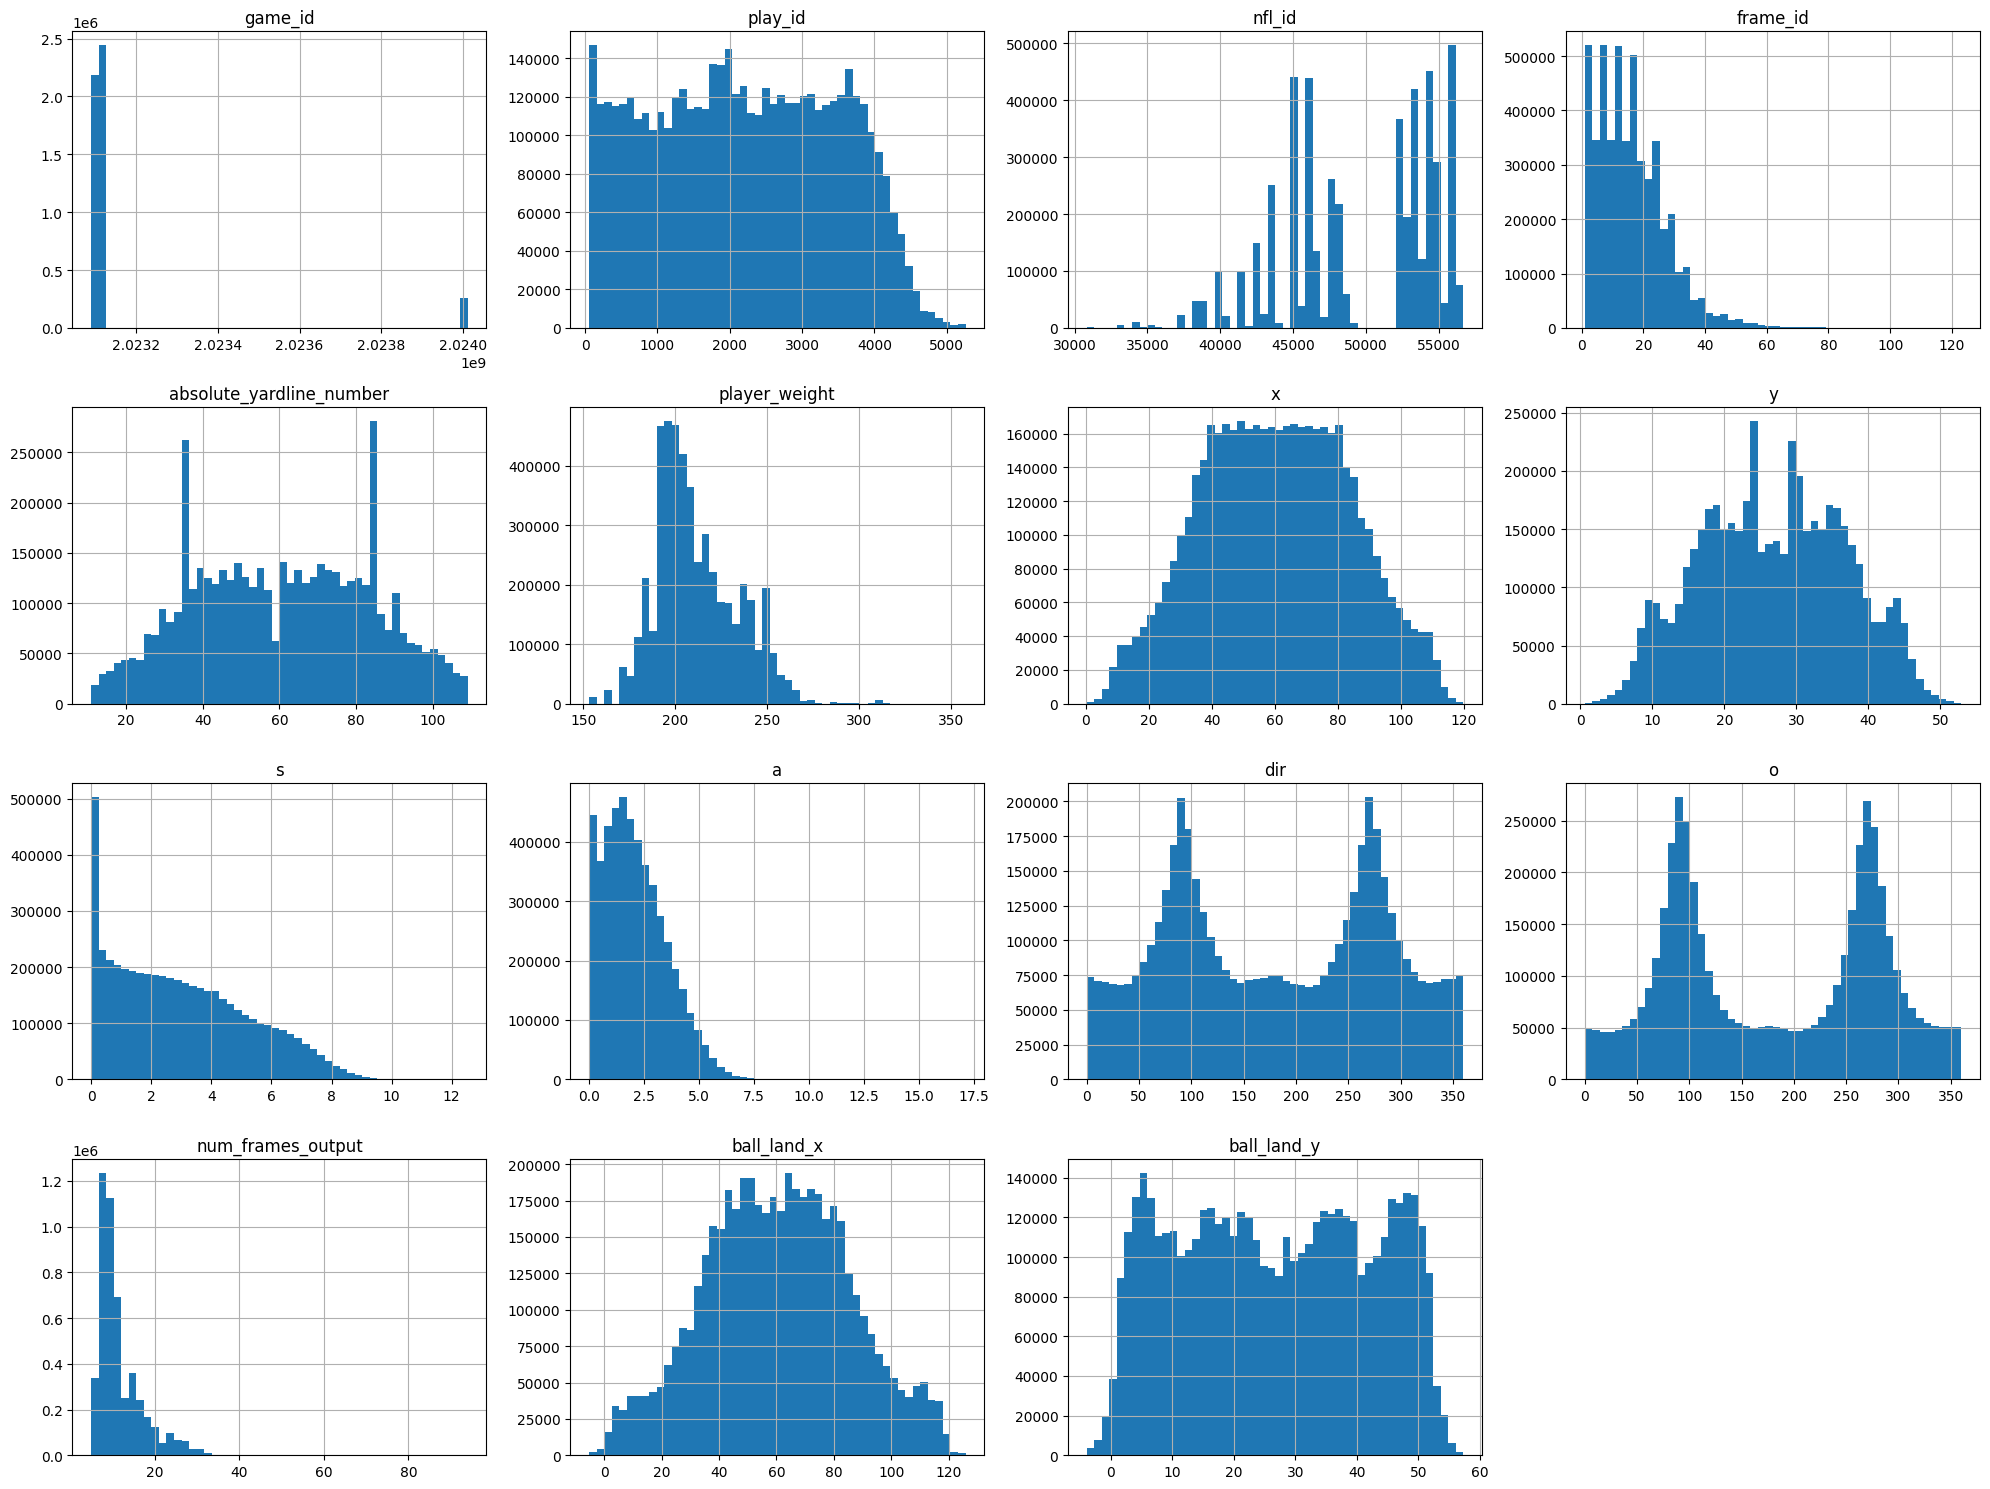

In [67]:
train_df.hist(bins=50, figsize=(20,15))
plt.tight_layout()
#plt.savefig('results/attribute_histogram_plots.pdf', format='pdf', dpi=300)#para grabar resultados en pdf
plt.show()

# Visualización espacial de los jugadores en el campo (Distribución por velocidad)


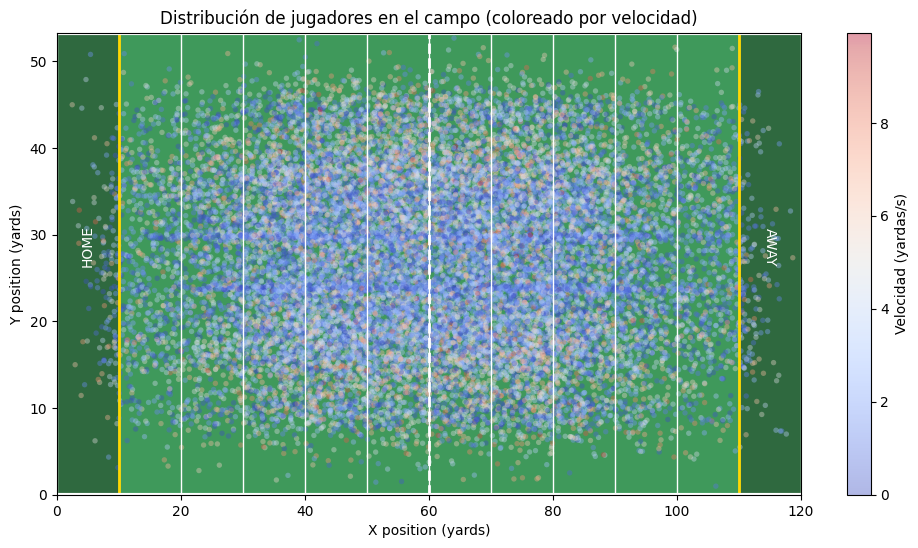

In [68]:
#funcion para simular el campo (graficar)
def draw_field(ax=None):
    if ax is None:
        ax = plt.gca()
    
    # Límites del campo (en yardas)
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 53.3)

    # Fondo verde del campo
    ax.add_patch(Rectangle((0, 0), 120, 53.3, linewidth=0, facecolor='#3f995b', zorder=0))

    # Líneas principales cada 10 yardas
    for x in range(0, 121, 10):
        ax.plot([x, x], [0, 53.3], color='white', linewidth=1)

    # Líneas de anotación (end zones)
    ax.plot([10, 10], [0, 53.3], color='gold', linewidth=2)
    ax.plot([110, 110], [0, 53.3], color='gold', linewidth=2)

    # Línea de medio campo
    ax.plot([60, 60], [0, 53.3], color='white', linewidth=2, linestyle='--')

    # Líneas de borde
    ax.plot([0, 120], [0, 0], color='white', linewidth=3)
    ax.plot([0, 120], [53.3, 53.3], color='white', linewidth=3)

    # End zones (fondos)
    ax.add_patch(Rectangle((0, 0), 10, 53.3, linewidth=0, facecolor='#2b5d38', alpha=0.8))
    ax.add_patch(Rectangle((110, 0), 10, 53.3, linewidth=0, facecolor='#2b5d38', alpha=0.8))

    # Texto
    ax.text(5, 26.65, 'HOME', color='white', fontsize=10, ha='center', rotation=90)
    ax.text(115, 26.65, 'AWAY', color='white', fontsize=10, ha='center', rotation=270)

    # Etiquetas y título
    ax.set_xlabel('X position (yards)')
    ax.set_ylabel('Y position (yards)')
    ax.set_title('Distribución de jugadores en el campo (coloreado por velocidad)')
    return ax


fig, ax = plt.subplots(figsize=(12, 6))
draw_field(ax)
subset = train_df.sample(20000)


sc = ax.scatter(
    subset['x'], subset['y'],
    c=subset['s'], cmap='coolwarm', alpha=0.4, s=15, edgecolor='none'
)

# Barra de color
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Velocidad (yardas/s)')

plt.show()


In [69]:
#id de las jugadas para visualizar cada una
train_df['play_id'].unique()

array([ 101,  194,  219, ..., 3679, 1037, 3490])

Mostrando jugada con play_id = 902, número de jugadores: 1802


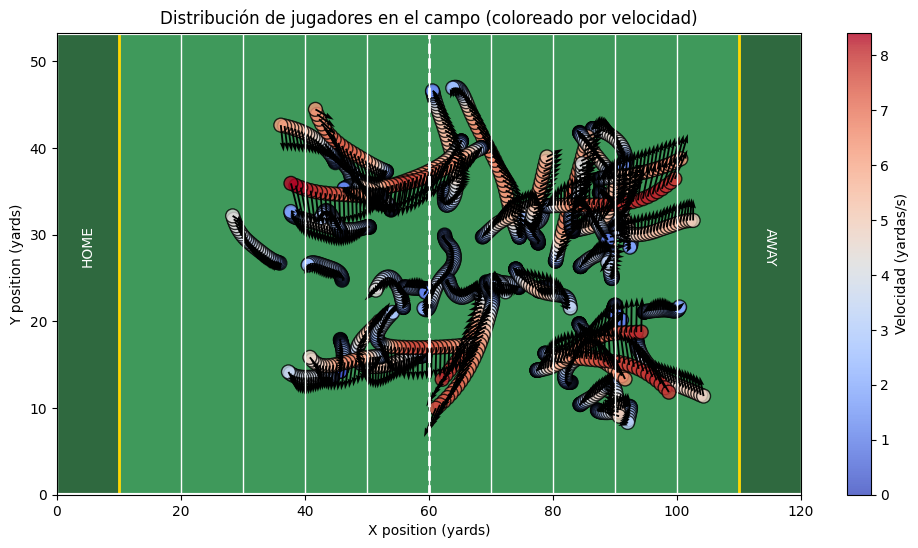

In [ ]:
# GRAFICAMOS 1 JUGADA/Seleccionar una jugada específica
play_id = train_df['play_id'].iloc[3679]  
play_df = train_df[train_df['play_id'] == play_id]

print(f"Mostrando jugada con play_id = {play_id}, número de jugadores: {len(play_df)}")

# Crear gráfico
fig, ax = plt.subplots(figsize=(12, 6))
draw_field(ax)

# Dibujar jugadores
sc = ax.scatter(
    play_df['x'], play_df['y'],
    c=play_df['s'], cmap='coolwarm', s=100, alpha=0.8, edgecolor='k'
)

# Dibujar direcciones como flechas
angles_rad = np.deg2rad(play_df['dir'])# Convertir dirección (en grados) a radianes
u = np.cos(angles_rad) * play_df['s'] / 2   # componente en x (escalado) --> se multiplica la velocidad por el movimiento
v = np.sin(angles_rad) * play_df['s'] / 2   # componente en y (escalado)

ax.quiver(
    play_df['x'], play_df['y'],
    u, v, #movimientos en los ejes
    angles='xy', scale_units='xy', scale=1, color='black', width=0.0025
)

# Barra de color (velocidad)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Velocidad (yardas/s)")

plt.show()


In [ ]:
#Variables numericas

numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns

print(numeric_cols)

Index(['game_id', 'play_id', 'nfl_id', 'frame_id', 'absolute_yardline_number',
       'player_weight', 'x', 'y', 's', 'a', 'dir', 'o', 'num_frames_output',
       'ball_land_x', 'ball_land_y'],
      dtype='object')


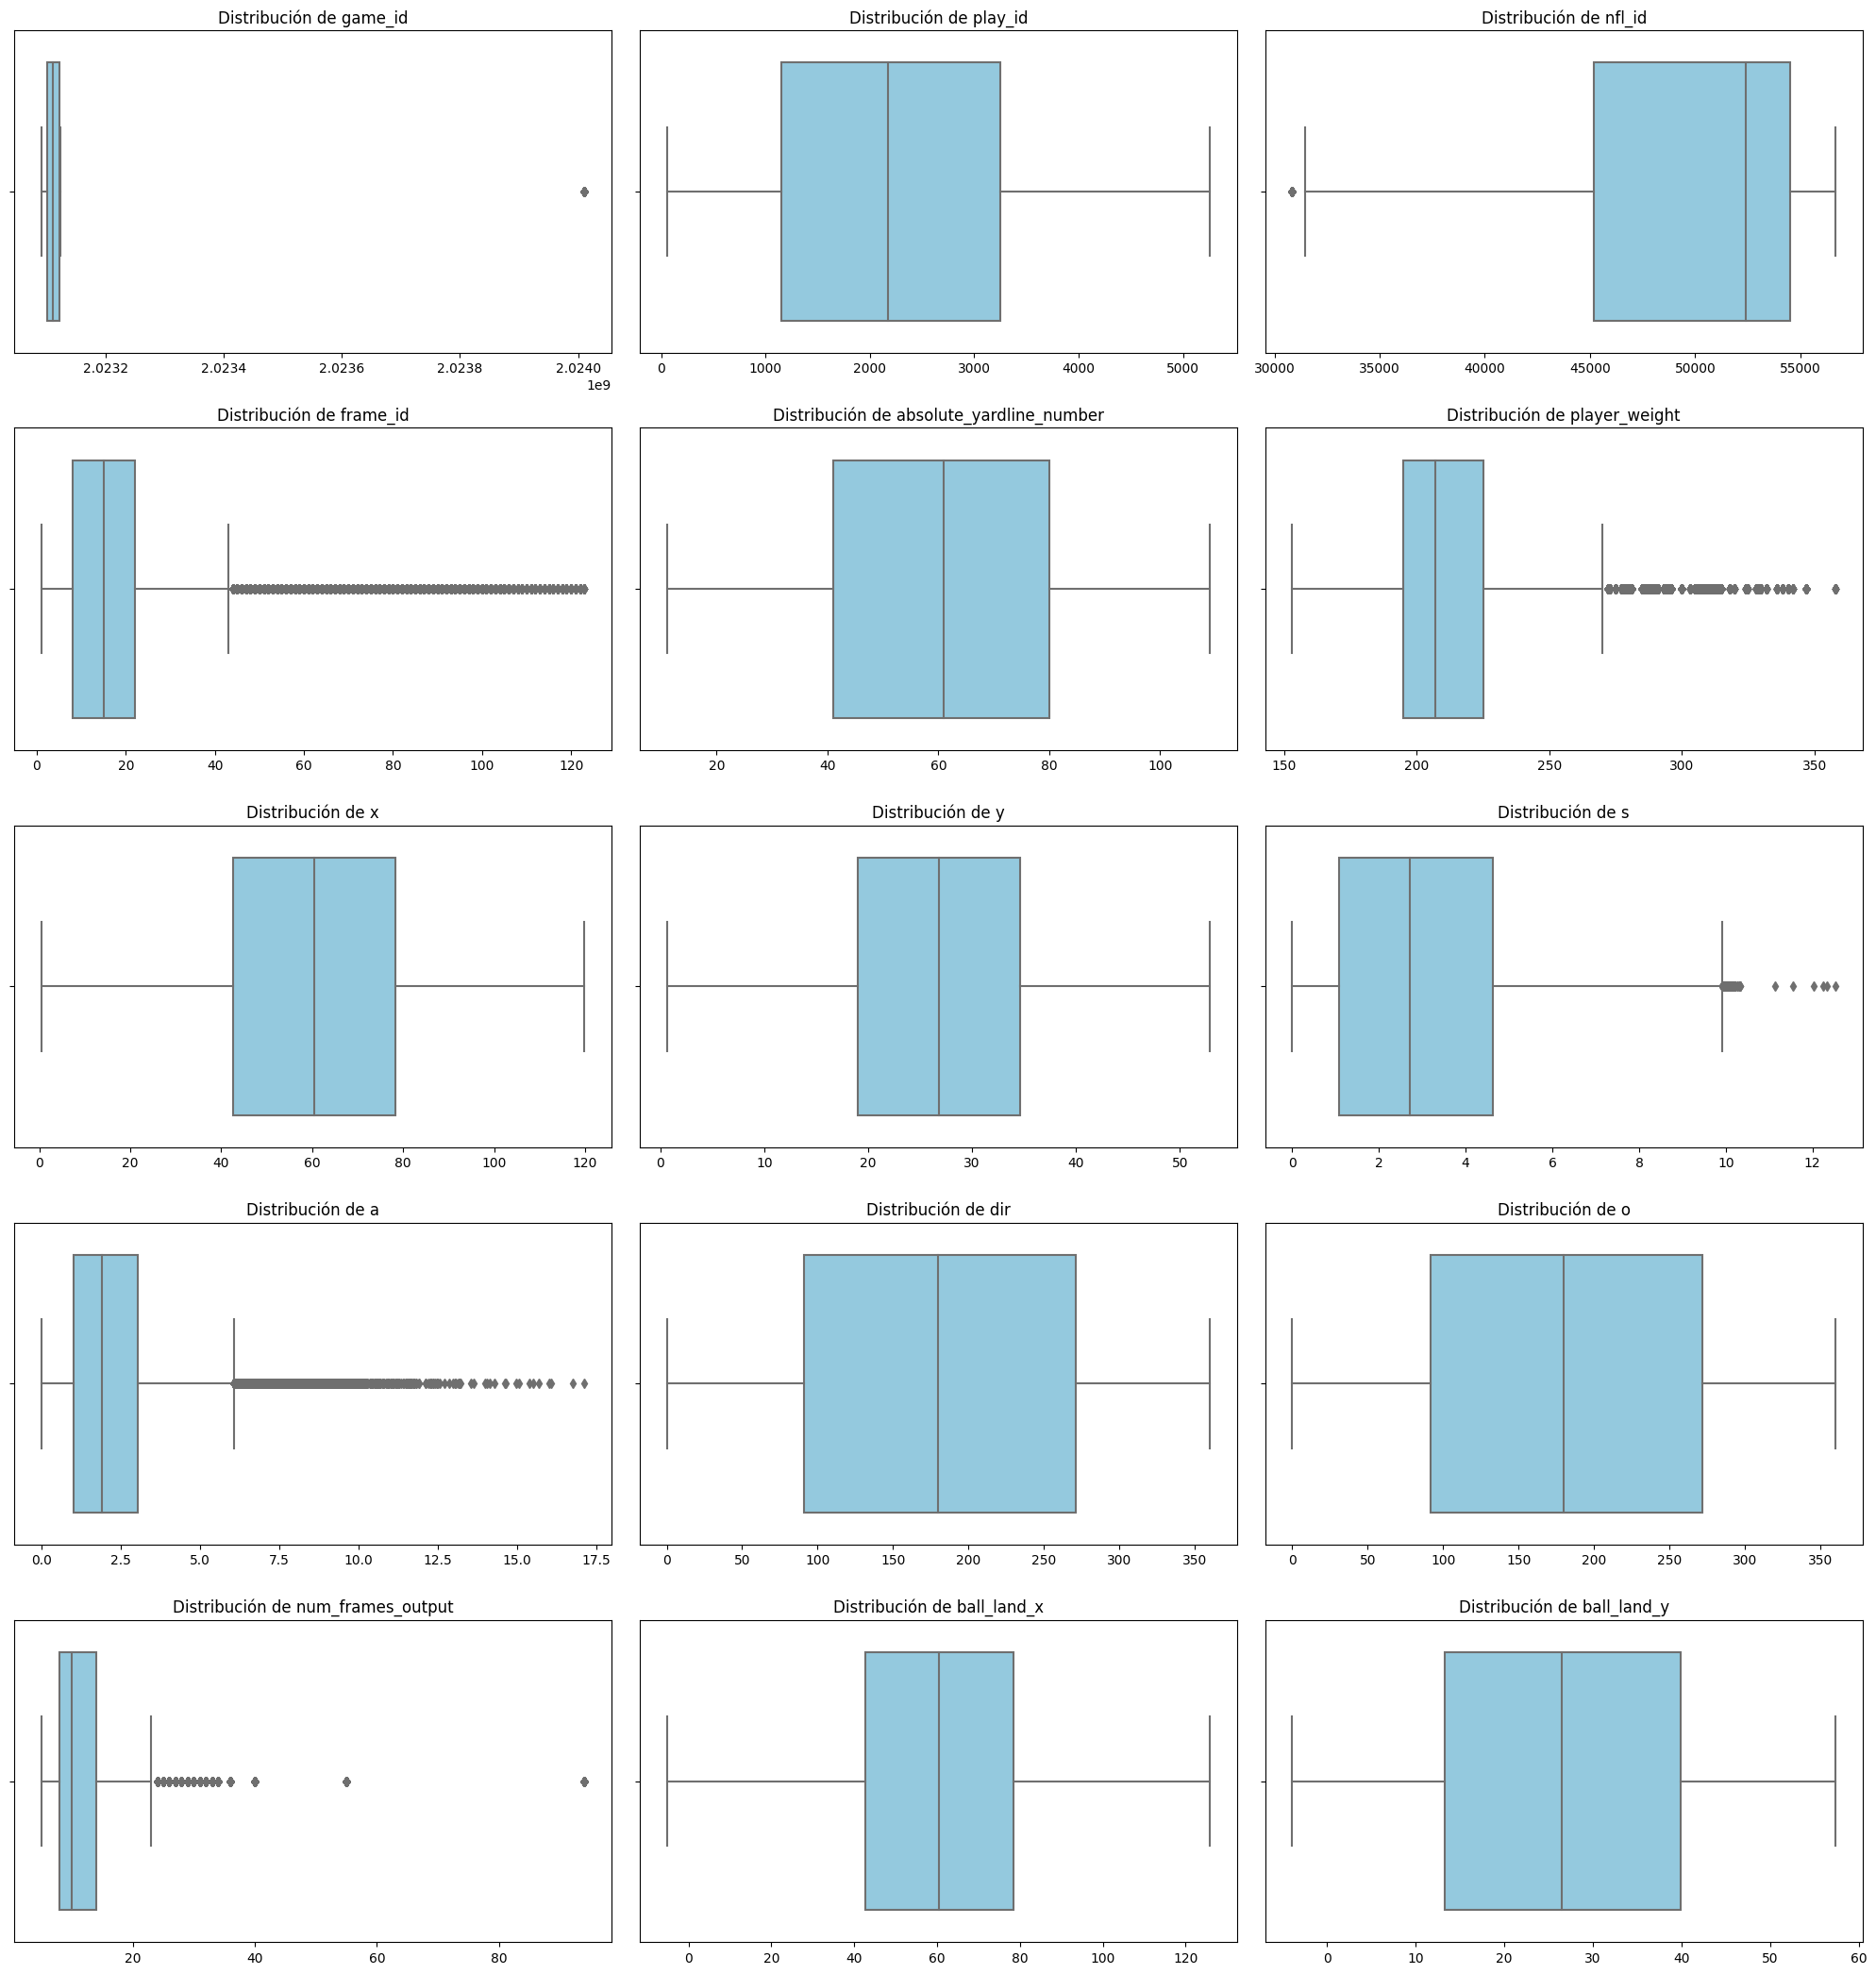

In [ ]:
#boxplot para ver la distribucion de nuestros datos 

plt.figure(figsize=(20, 25))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols)//3 + 1, 3, i)
    sns.boxplot(x=train_df[col], color='skyblue')
    plt.title(f'Distribución de {col}', fontsize=12)
    plt.xlabel('')
plt.tight_layout()
plt.show()


### Analisis boxplot
1. **Identificadores:** game_id, play_id, frame_id
2. **Outliers:** player_wight,s,a
3. **Bimodal:** dir,o
4. **sin problema:** absolute_yardline_number, ball_land_x, ball_land_y

In [ ]:
train_df[['s','a']].quantile([0.95, 0.99])


,s,a
0.95,7.08,4.74
0.99,8.22,5.81


In [ ]:
missing = train_df.isnull().mean() * 100
missing[missing > 0].sort_values(ascending=False)

Series([], dtype: float64)

In [ ]:
# Sesgo y curtosis/ para identificar distribucio real
skewness = train_df[["x", "y", "s", "a", "o", "dir", "player_weight"]].skew()
kurtosis = train_df[["x", "y", "s", "a", "o", "dir", "player_weight"]].kurt()

pd.DataFrame({"Sesgo": skewness, "Curtosis": kurtosis})


,Sesgo,Curtosis
x,0.012997,-0.668632
y,-0.004670,-0.790100
s,0.489582,-0.698358
a,0.636017,0.032648
o,-0.002102,-1.416443
dir,-0.000268,-1.300016
player_weight,0.621690,0.368460


### Analisis sesgo y curtosis
* **x:** platicurtica
* **y:** Simetrica
* **s:** Cola a la deracha
* **a:** Cola a la derecha
* **o:** Distribucion uniforme sobre angulos
* **dir:** Bimodal

“El análisis exploratorio evidencia que la mayoría de las variables presentan distribuciones simétricas con curtosis negativa, lo cual indica estabilidad y ausencia de valores extremos. Sin embargo, las variables s, a y player_weight muestran sesgo positivo, por lo que podrían beneficiarse de una transformación logarítmica para mejorar la normalidad en modelos paramétricos.”

### Creamos una copia de nuestra base de datos

trabajaremos con esta copia de ahora en adelante ya se le haran cambios y no queremos cambiar nuestra base datos real

In [ ]:
# Crear una copia del DataFrame original
df_clean = train_df.copy()

In [ ]:
df_clean.isnull().values.any()

False

### VALORES NAN

como pudimos ver, nuestra base de datos no cuenta con valores nulos

In [ ]:
# Duplicados
duplicados = df_clean.duplicated().sum()
print(f'Duplicados encontrados: {duplicados}')

Duplicados encontrados: 0


In [ ]:
df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_clean.dropna(subset=['x','y','s','a','o','dir','player_weight'], inplace=True)


### Normalizacion espacial

normalizaremos las jugadas en un solo sentido para reducir ruido y complejidad 

In [ ]:
def standardize_field_vectorized(df):
    
    df_new = df.copy() 
    left_plays = (df_new['play_direction'] == 'left')
    
    # 1. Invertir Coordenadas X y Y
    df_new.loc[left_plays, ['x', 'ball_land_x']] = 120 - df_new.loc[left_plays, ['x', 'ball_land_x']]
    df_new.loc[left_plays, ['y', 'ball_land_y']] = 53.3 - df_new.loc[left_plays, ['y', 'ball_land_y']]

    # 2. Invertir Ángulos (Dir y O)
    # Se usa la vectorización directamente: (Series + 180) % 360
    df_new.loc[left_plays, ['dir', 'o']] = (df_new.loc[left_plays, ['dir', 'o']] + 180) % 360
    
    return df_new


df_clean = standardize_field_vectorized(df_clean)

### Transformacion de radianes a Sen y Cos

esto se hace para evitar errores de similitud entre radianes y gran diferencia numerica, como por ejemplo el 0 y 360 que estarian en la misma posicion pero numericamente muy alejados

In [ ]:
df_clean = df_clean.drop(columns=['dir_rad', 'dir_sin', 'dir_cos', 'o_rad', 'o_sin', 'o_cos'], errors='ignore')

# Transformamos Dirección
df_clean['dir_sin'] = np.sin(np.deg2rad(df_clean['dir']))
df_clean['dir_cos'] = np.cos(np.deg2rad(df_clean['dir']))

# Transformamos Orientación 
df_clean['o_sin'] = np.sin(np.deg2rad(df_clean['o']))
df_clean['o_cos'] = np.cos(np.deg2rad(df_clean['o']))

df_clean = df_clean.drop(columns=['dir', 'o'], errors='ignore')

In [ ]:
df_clean.head()

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,y,s,a,num_frames_output,ball_land_x,ball_land_y,dir_sin,dir_cos,o_sin,o_cos
0,2023090700,101,False,54527,1,right,42,Bryan Cook,6-1,210,...,36.94,0.09,0.39,21,63.259998,-0.22,-0.610145,0.792290,-0.850260,-0.526362
1,2023090700,101,False,54527,2,right,42,Bryan Cook,6-1,210,...,36.94,0.04,0.61,21,63.259998,-0.22,-0.356575,-0.934267,-0.829525,-0.558469
2,2023090700,101,False,54527,3,right,42,Bryan Cook,6-1,210,...,36.93,0.12,0.73,21,63.259998,-0.22,0.536563,-0.843860,-0.871214,-0.490904
3,2023090700,101,False,54527,4,right,42,Bryan Cook,6-1,210,...,36.92,0.23,0.81,21,63.259998,-0.22,0.750111,-0.661312,-0.900698,-0.434445
4,2023090700,101,False,54527,5,right,42,Bryan Cook,6-1,210,...,36.90,0.35,0.82,21,63.259998,-0.22,0.836190,-0.548439,-0.900698,-0.434445


In [ ]:
# percentiles para decidir umbral 
df_clean['s'].quantile([0.90,0.95,0.99])
df_clean['a'].quantile([0.90,0.95,0.99])
df_clean['player_weight'].quantile([0.90,0.95,0.99])

# transformar/comprimir--> reduciremos el sesgo
df_clean['s_log1p'] = np.log1p(df_clean['s'])
df_clean['a_log1p'] = np.log1p(df_clean['a'])
df_clean['player_weight_log'] = np.log1p(df_clean['player_weight'])


In [ ]:
#revisar cantidad de categorias para verificar codificacion
cat_vars = ['player_side', 'player_role', 'play_direction']

for var in cat_vars:
    print(f"{var}: {df_clean[var].nunique()} categorías")
    print(df_clean[var].unique(), "\n")


player_side: 2 categorías
['Defense' 'Offense'] 

player_role: 4 categorías
['Defensive Coverage' 'Other Route Runner' 'Passer' 'Targeted Receiver'] 

play_direction: 2 categorías
['right' 'left'] 



### CODIFICACIONES

In [ ]:
# Label Encoding (para variables binarias)
label_vars = ['player_side']
for col in label_vars:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col])

# Verificación del resultado
print(train_df.shape)
train_df.head()


(4880579, 23)


,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
0,2023090700,101,False,54527,1,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.09,0.39,322.40,238.24,21,63.259998,-0.22
1,2023090700,101,False,54527,2,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.04,0.61,200.89,236.05,21,63.259998,-0.22
2,2023090700,101,False,54527,3,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.93,0.12,0.73,147.55,240.60,21,63.259998,-0.22
3,2023090700,101,False,54527,4,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.35,36.92,0.23,0.81,131.40,244.25,21,63.259998,-0.22
4,2023090700,101,False,54527,5,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.37,36.90,0.35,0.82,123.26,244.25,21,63.259998,-0.22


In [ ]:
onehot_vars = ['player_position', 'player_role']

# Aplicar One-Hot Encoding solo si aún no está hecho
if not any(col.startswith('player_position_') for col in df_clean.columns):
    df_clean = pd.get_dummies(df_clean, columns=onehot_vars, drop_first=False)

print("Shape final después del One-Hot Encoding:", df_clean.shape)

# Verificación rápida
df_clean.filter(regex='player_position_|player_role_').head()

Shape final después del One-Hot Encoding: (4880579, 49)


,player_position_CB,player_position_DE,player_position_DT,player_position_FB,player_position_FS,player_position_ILB,player_position_K,player_position_LB,player_position_MLB,player_position_NT,...,player_position_RB,player_position_S,player_position_SS,player_position_T,player_position_TE,player_position_WR,player_role_Defensive Coverage,player_role_Other Route Runner,player_role_Passer,player_role_Targeted Receiver
0,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [ ]:
# Convertir columnas booleanas a 0 y 1 (int8)
bool_cols = df_clean.select_dtypes(include='bool').columns
df_clean[bool_cols] = df_clean[bool_cols].astype('int8')

### lista de columnas despues de codificar

In [ ]:
print(df_clean.columns.tolist())

['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id', 'play_direction', 'absolute_yardline_number', 'player_name', 'player_height', 'player_weight', 'player_birth_date', 'player_side', 'x', 'y', 's', 'a', 'num_frames_output', 'ball_land_x', 'ball_land_y', 'dir_sin', 'dir_cos', 'o_sin', 'o_cos', 's_log1p', 'a_log1p', 'player_weight_log', 'player_position_CB', 'player_position_DE', 'player_position_DT', 'player_position_FB', 'player_position_FS', 'player_position_ILB', 'player_position_K', 'player_position_LB', 'player_position_MLB', 'player_position_NT', 'player_position_OLB', 'player_position_P', 'player_position_QB', 'player_position_RB', 'player_position_S', 'player_position_SS', 'player_position_T', 'player_position_TE', 'player_position_WR', 'player_role_Defensive Coverage', 'player_role_Other Route Runner', 'player_role_Passer', 'player_role_Targeted Receiver']


In [ ]:
# Convertir fecha de nacimiento a tipo datetime
df_clean['player_birth_date'] = pd.to_datetime(df_clean['player_birth_date'], errors='coerce') #coerce forza a los valores no validos

# Convertir altura de formato '6-2' (pies-pulgadas) a metros (versión vectorizada)
df_clean[['feet', 'inches']] = df_clean['player_height'].str.extract(r'(\d+)-(\d+)').astype(float)
df_clean['player_height_m'] = df_clean['feet'] * 0.3048 + df_clean['inches'] * 0.0254
df_clean.drop(columns=['feet', 'inches'], inplace=True)

# Edad del jugador (asumimos año 2025)
df_clean['player_age'] = 2025 - df_clean['player_birth_date'].dt.year # calculamos la edad 

# Índice de masa corporal (BMI)
df_clean['BMI'] = df_clean['player_weight'] / (df_clean['player_height_m'] ** 2)

# Componentes de velocidad (en yardas/s)
df_clean['velocity_x'] = df_clean['s'] * df_clean['dir_cos']
df_clean['velocity_y'] = df_clean['s'] * df_clean['dir_sin']


In [ ]:
numeric_vars_final = [
     'absolute_yardline_number',
    'player_height_m',
    'player_weight_log',  # mejor que usar weight crudo
    's_log1p', 'a_log1p',
    'dir_sin', 'dir_cos',
    'o_sin', 'o_cos',
    'BMI',
    'player_age' 
]
# estandarizamos nuestros datos
scaler = StandardScaler()
df_clean[numeric_vars_final] = scaler.fit_transform(df_clean[numeric_vars_final])

In [ ]:
# Seleccionar solo columnas numéricas
df_num = df_clean.select_dtypes(include=['int64', 'float64'])

# Calcular la matriz de correlación
corr_matrix = df_num.corr()

# Variables objetivo
targets = ['x', 'y']
target_scaler = StandardScaler()
df_clean[targets] = target_scaler.fit_transform(df_clean[targets])

# Mostrar correlación con cada objetivo
for target in targets:
    if target in corr_matrix.columns:
        print(f"\n🔹 Correlaciones con {target}:")
        display(corr_matrix[target].sort_values(ascending=False))



🔹 Correlaciones con x:


x                           1.000000
ball_land_x                 0.874306
frame_id                    0.083444
dir_sin                     0.063987
velocity_y                  0.060921
s_log1p                     0.039695
s                           0.038201
play_id                     0.033095
absolute_yardline_number    0.031108
o_cos                       0.023486
num_frames_output           0.005310
game_id                     0.001673
player_age                  0.001266
nfl_id                      0.000122
y                          -0.005155
ball_land_y                -0.008436
velocity_x                 -0.009177
dir_cos                    -0.010355
a_log1p                    -0.027158
a                          -0.031706
player_height_m            -0.055951
BMI                        -0.056223
player_weight_log          -0.074959
player_weight              -0.075412
o_sin                      -0.142942
player_side                -0.166222
Name: x, dtype: float64


🔹 Correlaciones con y:


y                           1.000000
velocity_x                  0.270526
dir_cos                     0.253913
ball_land_y                 0.050571
nfl_id                      0.019564
BMI                         0.002881
a                           0.002172
game_id                     0.002017
player_side                 0.001659
a_log1p                     0.001278
velocity_y                  0.001112
dir_sin                    -0.000044
absolute_yardline_number   -0.001097
num_frames_output          -0.001630
s                          -0.001900
s_log1p                    -0.002810
o_sin                      -0.003618
ball_land_x                -0.004828
x                          -0.005155
play_id                    -0.005784
player_weight_log          -0.007358
frame_id                   -0.007632
player_weight              -0.008608
player_height_m            -0.016777
player_age                 -0.017660
o_cos                      -0.183247
Name: y, dtype: float64

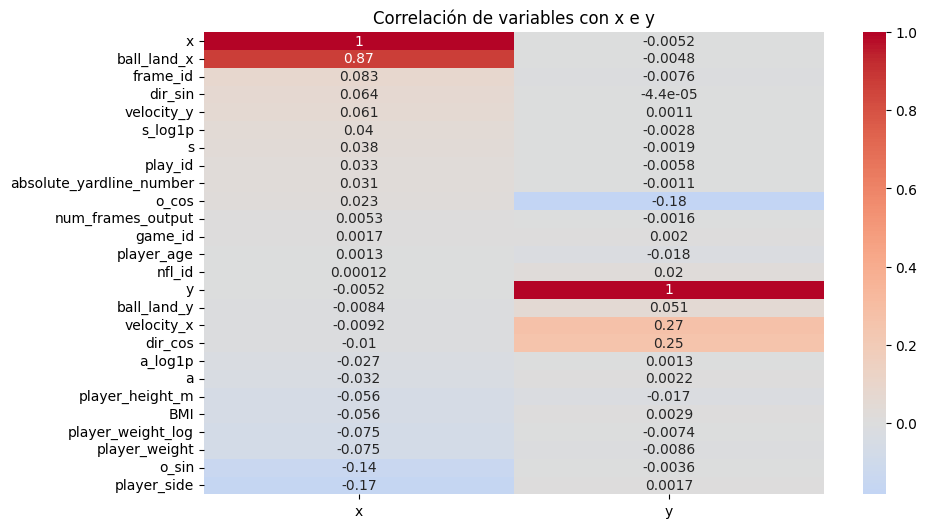

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix[['x', 'y']].sort_values(by='x', ascending=False),
            annot=True, cmap='coolwarm', center=0)
plt.title('Correlación de variables con x e y')
plt.show()


In [ ]:
#targets = ['x', 'y']
corr_mean = corr_matrix[targets].abs().mean(axis=1).sort_values(ascending=False)

print("🔸 Promedio de correlación absoluta con ambas salidas:")
display(corr_mean)


🔸 Promedio de correlación absoluta con ambas salidas:


x                           0.502577
y                           0.502577
ball_land_x                 0.439567
velocity_x                  0.139852
dir_cos                     0.132134
o_cos                       0.103367
player_side                 0.083941
o_sin                       0.073280
frame_id                    0.045538
player_weight               0.042010
player_weight_log           0.041158
player_height_m             0.036364
dir_sin                     0.032016
velocity_y                  0.031017
BMI                         0.029552
ball_land_y                 0.029503
s_log1p                     0.021253
s                           0.020050
play_id                     0.019439
a                           0.016939
absolute_yardline_number    0.016103
a_log1p                     0.014218
nfl_id                      0.009843
player_age                  0.009463
num_frames_output           0.003470
game_id                     0.001845
dtype: float64

In [ ]:
def calculate_relative_features(df):
    
    
    # Creamos un DataFrame que solo tiene la posición del jugador a predecir (BC)
    # Agrupamos por jugada y frame para obtener las coordenadas únicas del BC en ese momento
    bc_pos = df[df['player_to_predict'] == True].groupby(['game_id', 'play_id', 'frame_id'])[['x', 'y']].first().reset_index()
    bc_pos.columns = ['game_id', 'play_id', 'frame_id', 'bc_x', 'bc_y']
    

    df_new = pd.merge(df, bc_pos, on=['game_id', 'play_id', 'frame_id'], how='left')

    # 3. CALCULAR DISTANCIA EUCLIDIANA (Distancia de CADA jugador al BC)
    df_new['dist_to_bc'] = np.sqrt(
        (df_new['x'] - df_new['bc_x'])**2 + 
        (df_new['y'] - df_new['bc_y'])**2
    )
    
  
    df_new['dist_to_endzone'] = 120 - df_new['x'] # Distancia a la anotación final (estandarizada)
    
  
    defender_distances = df_new[df_new['player_side'] == 'Defense'].groupby(['game_id', 'play_id', 'frame_id'])['dist_to_bc']

    # Calculamos el mínimo y el promedio de la distancia de los defensores
    agg_distances = defender_distances.agg(['min', 'mean']).reset_index()
    agg_distances.columns = ['game_id', 'play_id', 'frame_id', 'min_dist_defender', 'mean_dist_defender']

   
    df_final = pd.merge(df_new, agg_distances, on=['game_id', 'play_id', 'frame_id'], how='left')
    
   
    # Eliminamos las columnas auxiliares
    df_final.drop(columns=['bc_x', 'bc_y', 'dist_to_bc'], errors='ignore', inplace=True)
    
    return df_final


df_clean = calculate_relative_features(df_clean)

In [ ]:
print(df_clean.columns.tolist())

['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id', 'play_direction', 'absolute_yardline_number', 'player_name', 'player_height', 'player_weight', 'player_birth_date', 'player_side', 'x', 'y', 's', 'a', 'num_frames_output', 'ball_land_x', 'ball_land_y', 'dir_sin', 'dir_cos', 'o_sin', 'o_cos', 's_log1p', 'a_log1p', 'player_weight_log', 'player_position_CB', 'player_position_DE', 'player_position_DT', 'player_position_FB', 'player_position_FS', 'player_position_ILB', 'player_position_K', 'player_position_LB', 'player_position_MLB', 'player_position_NT', 'player_position_OLB', 'player_position_P', 'player_position_QB', 'player_position_RB', 'player_position_S', 'player_position_SS', 'player_position_T', 'player_position_TE', 'player_position_WR', 'player_role_Defensive Coverage', 'player_role_Other Route Runner', 'player_role_Passer', 'player_role_Targeted Receiver', 'player_height_m', 'player_age', 'BMI', 'velocity_x', 'velocity_y', 'dist_to_endzone', 'min_dist_defender', '

In [ ]:
predictors_optimos = [
    
    'x', 'y', 'absolute_yardline_number', 
    
   
    'velocity_x', 'velocity_y',
    'dir_cos', 'dir_sin', 'o_cos', 'o_sin',
    's_log1p', 'a_log1p', 
    
  
    'BMI', 'player_height_m', 'player_weight_log', 
    'player_age', # o 'player_age_days'
    

    'num_frames_output',
    
  
    'player_position_CB', 'player_position_DE', 'player_role_Defensive Coverage', # ... y todas las demás OHE

    'min_dist_defender',       # Distancia al defensor más cercano
    'mean_dist_defender',      # Distancia media de todos los defensores
    
]

targets = ['ball_land_x', 'ball_land_y']

X = df_clean[predictors_optimos].apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)
y = df_clean[targets].apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Tamaños: {len(X_train)}, {len(X_val)}, {len(X_test)}")


X_train = X_train.to_numpy()
X_val   = X_val.to_numpy()
X_test  = X_test.to_numpy()

y_train = y_train.to_numpy()
y_val   = y_val.to_numpy()
y_test  = y_test.to_numpy()

print(f"Tipo de datos finales: {type(X_train)}, {type(y_train)}")

Tamaños: 2928347, 976116, 976116
Tipo de datos finales: <class 'numpy.ndarray'>, <class 'numpy.ndarray'>


In [ ]:
def safe_mape(y_true, y_pred):
    eps = 1e-6
    denom = np.where(np.abs(y_true) < eps, eps, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

# --------------------------------------------
# Función objetivo (para LightGBM con Optuna)
# --------------------------------------------
def objective_lgb(trial, X, y):
    dtrain = lgb.Dataset(X, label=y)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.7, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'seed': 42
    }

    cv_results = lgb.cv(
        params=params,
        train_set=dtrain,
        folds=KFold(n_splits=3, shuffle=True, random_state=42),
        num_boost_round=100,
        callbacks=[lgb.early_stopping(10, verbose=False)],
    )

    rmse_key = [k for k in cv_results.keys() if 'rmse-mean' in k][0]
    return np.min(cv_results[rmse_key])

# --------------------------------------------
# Entrenamiento y evaluación final
# --------------------------------------------
def tune_and_train(X_train, y_train, X_val, y_val, n_trials=5):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda t: objective_lgb(t, X_train, y_train), n_trials=n_trials, show_progress_bar=True)

    best = study.best_params
    print("\n✅ Mejores hiperparámetros encontrados:")
    for k, v in best.items():
        print(f"   - {k}: {v}")

    # Entrenar modelo final
    model = lgb.LGBMRegressor(**best, objective='regression', n_estimators=300)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[lgb.log_evaluation(20), lgb.early_stopping(10)]
    )
    return model, study


# --------------------------------------------
# Evaluación con métricas solicitadas
# --------------------------------------------
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred),
        "MAPE": safe_mape(y_test, y_pred)
    }

# --------------------------------------------
# Ejecución para cada target
# --------------------------------------------
print("🔹 Optimizando LightGBM para X...")
model_x, study_x = tune_and_train(X_train, y_train[:, 0], X_val, y_val[:, 0])

print("\n🔹 Optimizando LightGBM para Y...")
model_y, study_y = tune_and_train(X_train, y_train[:, 1], X_val, y_val[:, 1])

# Evaluación final (hold-out 20%)
metrics_x = evaluate_model(model_x, X_test, y_test[:, 0])
metrics_y = evaluate_model(model_y, X_test, y_test[:, 1])

print("\n📊 Resultados finales en conjunto de evaluación:")
for name, val in zip(["x_target", "y_target"], [metrics_x, metrics_y]):
    print(f"\n🔸 {name.upper()}")
    for k, v in val.items():
        print(f"   {k}: {v:.4f}")


[I 2025-12-03 17:27:01,350] A new study created in memory with name: no-name-60b16870-e59d-417c-b5c8-f483609658c2


🔹 Optimizando LightGBM para X...


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-12-03 17:27:55,300] Trial 0 finished with value: 4.8362489681669 and parameters: {'learning_rate': 0.18018935815692763, 'num_leaves': 70, 'feature_fraction': 0.8941413963806628, 'bagging_fraction': 0.7109265514735977, 'bagging_freq': 5, 'min_child_samples': 42}. Best is trial 0 with value: 4.8362489681669.
[I 2025-12-03 17:28:55,125] Trial 1 finished with value: 5.663202929847646 and parameters: {'learning_rate': 0.04338529282959157, 'num_leaves': 22, 'feature_fraction': 0.7168610043067218, 'bagging_fraction': 0.9137630254049823, 'bagging_freq': 4, 'min_child_samples': 10}. Best is trial 0 with value: 4.8362489681669.
[200]	valid_0's rmse: 4.63036	valid_0's l2: 21.4402
[220]	valid_0's rmse: 4.60394	valid_0's l2: 21.1962
[240]	valid_0's rmse: 4.57526	valid_0's l2: 20.933
[260]	valid_0's rmse: 4.55804	valid_0's l2: 20.7757
[280]	valid_0's rmse: 4.52968	valid_0's l2: 20.518


[I 2025-12-03 17:33:01,955] A new study created in memory with name: no-name-89e88a92-9e58-416a-aec0-aadce8df3a61


[300]	valid_0's rmse: 4.50093	valid_0's l2: 20.2583
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 4.50093	valid_0's l2: 20.2583

🔹 Optimizando LightGBM para Y...


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-12-03 17:33:40,262] Trial 0 finished with value: 14.105351427589985 and parameters: {'learning_rate': 0.1774641690046433, 'num_leaves': 68, 'feature_fraction': 0.7991294509990289, 'bagging_fraction': 0.743092414059816, 'bagging_freq': 1, 'min_child_samples': 33}. Best is trial 0 with value: 14.105351427589985.
[I 2025-12-03 17:34:52,885] Trial 1 finished with value: 14.95611582809218 and parameters: {'learning_rate': 0.021405204215668966, 'num_leaves': 99, 'feature_fraction': 0.7244574680296803, 'bagging_fraction': 0.9076440334848642, 'bagging_freq': 4, 'min_child_samples': 34}. Best is trial 0 with value: 14.105351427589985.
[I 2025-12-03 17:36:02,992] Trial 2 finished with value: 15.137303948041946 and parameters: {'learning_rate': 0.013102558958386551, 'num_leaves': 55, 'feature_fraction': 0.9641505991971715, 'bagging_fraction': 0.883274133088331, 'bagging_freq': 5, 'min_child_samples': 20}. Best is trial 0 with value: 14.105351427589985.
[I 2025-12-03 17:36:49,228] Trial 3 

In [ ]:
print(df_clean[predictors_optimos].dtypes)


In [ ]:
df_clean[predictors_optimos].applymap(type).nunique()


In [ ]:
!pip install --extra-index-url=https://pypi.nvidia.com \
cudf-cu12==24.08.* cuml-cu12==24.08.* cugraph-cu12==24.08.* cupy-cuda12x

     ━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.5/2.0 GB 13.9 MB/s eta 0:01:49^C
     ━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.5/2.0 GB 13.9 MB/s eta 0:01:49
ERROR: Operation cancelled by user


In [ ]:
!pip install lightgbm --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 33.6 MB/s eta 0:00:0000:0100:01
^C
ERROR: Operation cancelled by user


In [ ]:
print(type(y_train))
print(y_train.shape)
print(y_train[:5])


<class 'numpy.ndarray'>
(2928347, 2)
[[39.2      36.98    ]
 [80.87     48.11    ]
 [65.22     20.869999]
 [35.16     39.39    ]
 [64.       49.49    ]]


In [ ]:
# Reproducibilidad--> semilla
random.seed(42)
np.random.seed(42)


def safe_mape(y_true, y_pred):
    eps = 1e-6
    denom = np.where(np.abs(y_true) < eps, eps, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100


def tune_and_train(X_train, y_train, X_val, y_val, n_trials=5):
    def objective(trial):
        params = {
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
            'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 5.0),
            'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 5.0),
            'device': 'gpu'
        }

        model = lgb.LGBMRegressor(**params, objective='regression')

        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='rmse',
            callbacks=[lgb.early_stopping(20, verbose=False)]
        )

        preds = model.predict(X_val)
        rmse = np.sqrt(np.mean((preds - y_val) ** 2))
        return rmse

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    best = study.best_params

    model = lgb.LGBMRegressor(**best, objective='regression', n_estimators=300)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(20, verbose=False)]
    )

    return model, study


def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred),
        "MAPE": safe_mape(y_test, y_pred)
    }


# ============================================================
# [BLOQUE 3: ENTRENAMIENTO FINAL]
# ============================================================
print("\n🔹 Optimizando LightGBM para X (ball_land_x)...")
model_x, study_x = tune_and_train(X_train, y_train[:, 0], X_val, y_val[:, 0])

print("\n🔹 Optimizando LightGBM para Y (ball_land_y)...")
model_y, study_y = tune_and_train(X_train, y_train[:, 1], X_val, y_val[:, 1])

metrics_x = evaluate_model(model_x, X_test, y_test[:, 0])
metrics_y = evaluate_model(model_y, X_test, y_test[:, 1])

print("\n📊 Resultados finales:")
for name, val in zip(["x_target", "y_target"], [metrics_x, metrics_y]):
    print(f"\n🔸 {name.upper()}")
    for k, v in val.items():
        print(f"    {k}: {v:.4f}")


[I 2025-12-03 17:41:32,571] A new study created in memory with name: no-name-97f5720f-b0a7-4362-9a98-fe957987af83



🔹 Optimizando LightGBM para X (ball_land_x)...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
[I 2025-12-03 17:41:54,910] Trial 0 finished with value: 5.501052946316188 and parameters: {'num_leaves': 30, 'max_depth': 3, 'learning_rate': 0.2775301319623021, 'feature_fraction': 0.7638462218102664, 'bagging_fraction': 0.6228943357200424, 'bagging_freq': 7, 'lambda_l1': 2.87533188688817, 'lambda_l2': 4


🔹 Optimizando LightGBM para Y (ball_land_y)...


[I 2025-12-03 17:44:51,410] Trial 0 finished with value: 14.897462789690573 and parameters: {'num_leaves': 32, 'max_depth': 4, 'learning_rate': 0.16811426296959475, 'feature_fraction': 0.8481508094332461, 'bagging_fraction': 0.7026536450523797, 'bagging_freq': 2, 'lambda_l1': 3.711682175720087, 'lambda_l2': 4.612771055312669}. Best is trial 0 with value: 14.897462789690573.
[I 2025-12-03 17:45:12,940] Trial 1 finished with value: 13.819834688021368 and parameters: {'num_leaves': 72, 'max_depth': 9, 'learning_rate': 0.2298731725421156, 'feature_fraction': 0.909888223477663, 'bagging_fraction': 0.8080240741728439, 'bagging_freq': 7, 'lambda_l1': 4.516332027963989, 'lambda_l2': 0.19422776885367699}. Best is trial 1 with value: 13.819834688021368.
[I 2025-12-03 17:45:30,542] Trial 2 finished with value: 15.247010774942368 and parameters: {'num_leaves': 31, 'max_depth': 3, 'learning_rate': 0.01445397904049751, 'feature_fraction': 0.7890982838782814, 'bagging_fraction': 0.7621752195240613, '

KeyboardInterrupt: 

### Descripcion de variables

### Variables de entrada
1. game_id (id partido) — identificador.
2. play_id (id jugada) — identificador (útil para agrupamiento).
3. nfl_id (id jugador) — identificador.
4. frame_id — instante temporal (1..N).
5. play_direction — dirección del avance (left/right) — codificar binario.
6. absolute_yardline_number — posición en yardas (numérica).
7. player_height_m, player_weight_log, BMI — atributos físicos procesados.
8. player_position_* one-hot — posición (CB, WR, ...).
9. player_role_* one-hot — rol en la jugada.
10. x, y (posición actual) — coordenadas input (último frame antes del pase).
11. s, a — velocidad y aceleración instantáneas.
12. dir_sin, dir_cos, o_sin, o_cos — direcciones transformadas para evitar discontinuidad angular.
13. velocity_x, velocity_y — componentes de velocidad si las derivaste.
14. num_frames_output — número de frames a predecir (puede usarse como feature).
15. ball_land_x, ball_land_y — coordenadas donde aterriza el balón

### Variables de salida
x_target, y_target (o x, y de frames objetivo). En la competencia el objetivo es predecir coordenadas (x,y) en frames posteriores.

### Variables secuenciales 

**['x','y','s','a','dir_sin','dir_cos','o_sin','o_cos','velocity_x','velocity_y']**

### Variables estaticas

**['player_height_m','player_age','BMI',
 'absolute_yardline_number','player_weight_log',
 'dist_to_endzone','min_dist_defender','mean_dist_defender']**

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


In [109]:
RND = 42
random.seed(RND)
np.random.seed(RND)
torch.manual_seed(RND)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# metric helpers
def mape(y_true, y_pred):
    denom = np.where(np.abs(y_true) < 1e-6, 1.0, np.abs(y_true))
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

def evaluate_multi(y_true, y_pred):
    """y_true, y_pred shape: (N, T, 2)"""
    results = {}
    N,T,_ = y_true.shape
    mae_list=[]; mse_list=[]; r2_list=[]; mape_list=[]
    for t in range(T):
        yt = y_true[:,t,:]
        yp = y_pred[:,t,:]
        # if all zeros masked rows exist, ensure shapes
        mae = mean_absolute_error(yt, yp)
        mse = mean_squared_error(yt, yp)
        r2  = r2_score(yt, yp)
        mape_ = mape(yt, yp)
        results[f'frame{t+1}_MAE'] = mae
        results[f'frame{t+1}_MSE'] = mse
        results[f'frame{t+1}_R2']  = r2
        results[f'frame{t+1}_MAPE'] = mape_
        mae_list.append(mae); mse_list.append(mse); r2_list.append(r2); mape_list.append(mape_)
    # aggregate
    results['MAE_mean'] = np.mean(mae_list)
    results['MSE_mean'] = np.mean(mse_list)
    results['R2_mean']  = np.mean(r2_list)
    results['MAPE_mean']= np.mean(mape_list)
    return results

In [110]:
def build_sequences(df, seq_len=10):
    X_seq = []
    X_static = []
    Y = []

    seq_cols = [
        'x', 'y',
        's_log1p', 'a_log1p',
        'dir_sin', 'dir_cos',
        'o_sin', 'o_cos'
    ]

    static_cols = [
        'absolute_yardline_number',
        'player_height_m',
        'player_weight_log',
        'BMI',
        'player_age'
    ]

    target_cols = ['x', 'y']

    dropped_players = 0

    for (_, group) in df.groupby(['game_id', 'play_id', 'nfl_id']):
        
        group = group.sort_values('frame_id').reset_index(drop=True)

        # Chequeo de NaNs
        if group[seq_cols + static_cols].isna().any().any():
            dropped_players += 1
            continue

        if len(group) < seq_len + 1:
            continue

        seq_input = group.iloc[:seq_len][seq_cols].values
        
        frames_out = int(group['num_frames_output'].iloc[0])

        if len(group) < seq_len + frames_out:
            continue

        seq_target = group.iloc[seq_len:seq_len + frames_out][target_cols].values
        
        static_input = group.iloc[0][static_cols].values

        X_seq.append(seq_input)
        X_static.append(static_input)
        Y.append(seq_target)

    print(f"[INFO] Jugadores eliminados por NaNs: {dropped_players}")

    return np.array(X_seq), np.array(X_static), Y

In [111]:
df_clean['num_frames_output'] = df_clean['num_frames_output'].astype(int)


In [112]:
SEQ_LEN = 10
X_seq, X_static, Y = build_sequences(df_clean)

print(X_seq.shape)
print(X_static.shape)
print(len(Y))
print(Y[0].shape)


[INFO] Jugadores eliminados por NaNs: 0
(141321, 10, 8)
(141321, 5)
141321
(9, 2)


In [113]:
from sklearn.model_selection import train_test_split

# Primero train (60%) y temp (40%)
X_seq_train, X_seq_temp, X_static_train, X_static_temp, Y_train, Y_temp = train_test_split(
    X_seq, X_static, Y, test_size=0.40, random_state=42
)

# Luego temp → valid/test (20/20)
X_seq_valid, X_seq_test, X_static_valid, X_static_test, Y_valid, Y_test = train_test_split(
    X_seq_temp, X_static_temp, Y_temp, test_size=0.50, random_state=42
)


In [114]:
# Ensure static features are float32 (fix dtype=object issue)
X_static_train = np.asarray(X_static_train).astype(np.float32)
X_static_valid = np.asarray(X_static_valid).astype(np.float32)
X_static_test  = np.asarray(X_static_test).astype(np.float32)


In [123]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import time
import math

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torchmetrics.functional import mean_squared_error
import math

In [124]:
class NFLDataset(Dataset):
    def __init__(self, X_seq, X_static, Y):
        self.X_seq = torch.tensor(X_seq, dtype=torch.float32)
        self.X_static = torch.tensor(X_static, dtype=torch.float32)
        self.Y = [torch.tensor(y, dtype=torch.float32) for y in Y]

        # Validación de NaNs
        if torch.isnan(self.X_seq).any():
            raise ValueError("NaNs detectados en X_seq")

        if torch.isnan(self.X_static).any():
            raise ValueError("NaNs detectados en X_static")

        for i, target in enumerate(self.Y):
            if torch.isnan(target).any():
                raise ValueError(f"NaNs detectados en Y[{i}]")
                
    def __len__(self):
        return len(self.X_seq)

    
    def __getitem__(self, idx):
        return self.X_seq[idx], self.X_static[idx], self.Y[idx]


def collate_fn(batch, global_max_len=None):
    seqs, statics, ys = zip(*batch)

    seqs = torch.stack(seqs, dim=0)
    statics = torch.stack(statics, dim=0)

    lengths = [y.shape[0] for y in ys]
    B = len(ys)

    # si no se pasa un max global, usar el max del batch
    T_max = global_max_len if global_max_len is not None else max(lengths)

    y_padded = torch.zeros((B, T_max, 2), dtype=torch.float32)
    tgt_mask = torch.zeros((B, T_max), dtype=torch.bool)

    for i, y in enumerate(ys):
        L = y.shape[0]
        y_padded[i, :L] = y
        tgt_mask[i, :L] = True

    tgt_lens = torch.tensor(lengths, dtype=torch.long)
    return seqs, statics, y_padded, tgt_lens, tgt_mask


# -------------------------
# Positional Encoding
# -------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        # Create constant pos encoding matrix (max_len, d_model)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (B, L, d_model)
        L = x.size(1)
        return x + self.pe[:, :L, :]


# -------------------------
# Modelo híbrido
# -------------------------
class TransformerTrajectoryModel(nn.Module):
    def __init__(self,
                 seq_input_dim: int,
                 static_input_dim: int,
                 d_model: int = 384,
                 nhead: int = 8,
                 num_encoder_layers: int = 4,
                 num_decoder_layers: int = 3,
                 dim_feedforward: int = 2048,
                 dropout: float = 0.2,
                 max_target_len: int = 50):
        """
        seq_input_dim: número de features por frame (ej. 8)
        static_input_dim: número de features estáticas (ej. 5)
        d_model: tamaño embedding para Transformer
        max_target_len: máximo número de frames a predecir (para embeddings posicionales)
        """
        super().__init__()
        self.d_model = d_model
        # proyectar features de secuencia a d_model
        self.input_proj = nn.Linear(seq_input_dim, d_model)

        # encoder: TransformerEncoder (PyTorch)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                   dim_feedforward=dim_feedforward, dropout=dropout,
                                                   activation='relu', batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        # positional encodings (para encoder inputs)
        self.pos_encoder = PositionalEncoding(d_model=d_model, max_len=500)

        # static MLP -> produce embedding (d_model dim) que será concatenada (broadcast) al decoder input
        self.static_mlp = nn.Sequential(
            nn.Linear(static_input_dim, d_model),
            nn.ReLU(),
            nn.LayerNorm(d_model)
        )

        # Decoder side: proyectamos "previous outputs" (x,y) to d_model
        self.tgt_input_proj = nn.Linear(2, d_model)  # decoder consumes previous (x,y)
        self.pos_decoder = PositionalEncoding(d_model=d_model, max_len=max_target_len+5)

        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead,
                                                   dim_feedforward=dim_feedforward, dropout=dropout,
                                                   activation='relu', batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        # Output head: d_model -> 2 (x,y)
        self.output_head = nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, 2)
        )

        # small init
        self._reset_parameters()

    def _reset_parameters(self):
        # initializer: standard
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src_seq, src_static, tgt_inputs=None, tgt_mask=None, teacher_forcing_prob=0.9):
        """
        src_seq: (B, seq_len, seq_feats)
        src_static: (B, n_static)
        tgt_inputs: during training: (B, T, 2) (ground truth shifted right),
                    if None -> we will autoregresively predict
        tgt_mask: bool (B, T) True where target exists (to compute loss)
        teacher_forcing_prob: probabilidad de usar teacher forcing en entrenamiento
        Returns: preds (B, T, 2)
        """
        B = src_seq.size(0)
        device = src_seq.device

        # encode src sequence
        x = self.input_proj(src_seq)                # (B, seq_len, d_model)
        x = self.pos_encoder(x)
        memory = self.encoder(x)                    # (B, seq_len, d_model)

        # static embedding
        static_emb = self.static_mlp(src_static)    # (B, d_model)

        # prepare decoder memory: we will use memory (encoder output) as memory
        # prepare autoregressive decoding
        if tgt_inputs is not None:
            # training mode: we will use teacher forcing per step
            T = tgt_inputs.size(1)
            # shift-right for decoder input: standard technique: feed <sos>=last src pos? we'll use last src (x,y)
            # create decoder inputs: start token = last frame (we'll use src_seq[:, -1, :2] which are x,y)
            last_src_xy = src_seq[:, -1, :2]  # (B,2)
            dec_inp = torch.zeros((B, T, 2), device=device)
            dec_inp[:, 0, :] = last_src_xy
            # if T>1, fill with teacher forcing or placeholders
            for t in range(1, T):
                # with probability teacher_forcing_prob use true previous; else use predicted (we'll do hybrid)
                if torch.rand(1).item() < teacher_forcing_prob:
                    dec_inp[:, t, :] = tgt_inputs[:, t-1, :]  # feed true prev
                else:
                    # placeholder zero, will be filled in autoreg loop below; but for transformer batch we keep true prev
                    dec_inp[:, t, :] = tgt_inputs[:, t-1, :]  # for simplicity use teacher; can be enhanced
            # project tgt inputs
            dec_proj = self.tgt_input_proj(dec_inp)   # (B, T, d_model)
            dec_proj = self.pos_decoder(dec_proj)
            # create padding masks for transformer: PyTorch expects mask with True = to ignore
            if tgt_mask is not None:
                # tgt_key_padding_mask shape => (B, T) True for PAD. Our tgt_mask True for valid -> invert
                tgt_key_padding_mask = ~tgt_mask
            else:
                tgt_key_padding_mask = None

            # decoder: queries are dec_proj, memory is encoder memory
            # we also broadcast the static_emb by adding it to decoder inputs (as bias)
            dec_input = dec_proj + static_emb.unsqueeze(1)  # (B, T, d_model)
            # causal mask for decoder (prevent peeking future) - using transformer's tgt mask
            tgt_seq_len = dec_input.size(1)
            causal_mask = generate_square_subsequent_mask(tgt_seq_len).to(device)  # (T,T)
            dec_out = self.decoder(tgt=dec_input, memory=memory,
                                   tgt_mask=causal_mask,
                                   tgt_key_padding_mask=tgt_key_padding_mask)
            preds = self.output_head(dec_out)  # (B, T, 2)
            return preds

        else:
            # Inference: autoregressive step-by-step
            # we will predict up to a max_length (choose max_target_len)
            max_len = self.max_target_len
            preds_list = []
            prev = src_seq[:, -1, :2]  # last xy (B,2)
            memory = memory
            static_emb = static_emb
            for t in range(max_len):
                # project prev
                p = self.tgt_input_proj(prev.unsqueeze(1))  # (B,1,d_model)
                p = self.pos_decoder(p)  # pos enc based on t? pos decoder adds position along first dim; acceptable
                dec_input = p + static_emb.unsqueeze(1)
                # decode single step: use decoder with memory and no tgt_mask (length=1)
                dec_out = self.decoder(tgt=dec_input, memory=memory)  # (B,1,d_model)
                out_xy = self.output_head(dec_out.squeeze(1))  # (B,2)
                preds_list.append(out_xy)
                prev = out_xy
            preds = torch.stack(preds_list, dim=1)  # (B, max_len, 2)
            return preds


def generate_square_subsequent_mask(sz):
    """Causal mask for Transformer decoder (PyTorch format expects float mask or bool)."""
    mask = torch.triu(torch.ones((sz, sz), dtype=torch.bool), diagonal=1)
    # True values will be masked (i.e., ignored). We'll return mask where True indicates masked positions.
    return mask


def mape_numpy(y_true, y_pred):
    denom = np.where(np.abs(y_true) < 1e-6, 1.0, np.abs(y_true))
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
# NOTA: no importamos mean_squared_error aquí a nivel global para evitar colisiones

def evaluate_predictions(y_true_padded, y_true_lens, y_pred_padded):
    """
    y_true_padded: (B, T_max, 2) numpy
    y_true_lens: (B,) lengths
    y_pred_padded: (B, T_max, 2) numpy (predictions, may be padded)
    Returns dict with MAE, MSE, RMSE, R2, MAPE
    """
    # asegúrate de que entran numpy arrays
    y_true_padded = np.asarray(y_true_padded)
    y_pred_padded = np.asarray(y_pred_padded)
    y_true_lens = np.asarray(y_true_lens)

    B, T, _ = y_true_padded.shape
    all_true = []
    all_pred = []

    for i in range(B):
        L = int(y_true_lens[i])
        if L == 0:
            continue
        all_true.append(y_true_padded[i, :L, :])
        all_pred.append(y_pred_padded[i, :L, :])

    if len(all_true) == 0:
        # fallback: no data
        return {'MAE': np.nan, 'MSE': np.nan, 'RMSE': np.nan, 'R2': np.nan, 'MAPE': np.nan}

    all_true = np.vstack(all_true)
    all_pred = np.vstack(all_pred)

    # IMPORT seguro dentro de la función — evita colisiones en el namespace
    from sklearn.metrics import mean_squared_error as _sk_mse

    mae = mean_absolute_error(all_true, all_pred)
    mse = _sk_mse(all_true, all_pred)   # ahora forzosamente sklearn
    rmse = float(np.sqrt(mse))
    r2 = r2_score(all_true, all_pred)
    mape = mape_numpy(all_true, all_pred)

    return {'MAE': float(mae), 'MSE': float(mse), 'RMSE': float(rmse), 'R2': float(r2), 'MAPE': float(mape)}



In [126]:

def train_model(model: nn.Module,
                train_loader: DataLoader,
                val_loader: DataLoader,
                n_epochs: int = 20,
                lr: float = 3e-4,
                device: str = None,
                save_path: str = './model_checkpoint.pth'):
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
    criterion = nn.MSELoss(reduction='none')  # we'll mask manually

    best_val_mae = float('inf')
    best_val_rmse = float('inf')
    for epoch in range(1, n_epochs+1):
        model.train()
        t0 = time.time()
        train_losses = []

        for batch_idx, (seqs, statics, y_padded, y_lens, tgt_mask) in enumerate(train_loader):
            seqs = seqs.to(device)               # (B, seq_len, seq_feats)
            statics = statics.to(device)
            y_padded = y_padded.to(device)
            tgt_mask = tgt_mask.to(device)

            
            preds = model(seqs, statics, tgt_inputs=y_padded, tgt_mask=tgt_mask, teacher_forcing_prob=0.5)  # (B, T, 2)

            # compute masked loss
            mask = tgt_mask.unsqueeze(-1).float()  # (B, T, 1)
            loss_matrix = criterion(preds, y_padded) * mask  # (B, T, 2)
            loss = loss_matrix.sum() / (mask.sum() * 2.0)  # average per actual value
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

            train_losses.append(loss.item())

        # validation
        model.eval()
        val_preds = []
        val_trues = []
        val_lens = []
        with torch.no_grad():
            for seqs, statics, y_padded, y_lens, tgt_mask in val_loader:
                seqs = seqs.to(device)
                statics = statics.to(device)
                y_padded = y_padded.to(device)
                tgt_mask = tgt_mask.to(device)

                preds = model(seqs, statics, tgt_inputs=y_padded, tgt_mask=tgt_mask, teacher_forcing_prob=0.0)
                # preds: (B, T, 2)
                # move to cpu numpy for metric
                val_preds.append(preds.cpu().numpy())
                val_trues.append(y_padded.cpu().numpy())
                val_lens.append(y_lens.numpy())

        val_preds = np.vstack(val_preds)  # (N_val_batches*B, T_max, 2)
        val_trues = np.vstack(val_trues)
        val_lens = np.concatenate(val_lens)

        metrics = evaluate_predictions(val_trues, val_lens, val_preds)
        val_mae = metrics['MAE']
        val_rmse = metrics['RMSE']
        scheduler.step(val_mae)

        mean_train_loss = np.mean(train_losses)
        elapsed = time.time() - t0
        print(f"Epoch {epoch}/{n_epochs} - train_loss: {mean_train_loss:.6f} - val_MAE: {val_mae:.6f} - val_RMSE: {val_rmse:.6f} - time: {elapsed:.1f}s")


        # checkpoint best
        # Guardar por MAE
        if val_mae < best_val_mae:
            best_val_mae = val_mae
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_mae': val_mae,
                'val_rmse': val_rmse
            }, './best_by_mae.pth')
            print("Saved best model by MAE.")

        # Guardar por RMSE (métrica de competencia)
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_mae': val_mae,
                'val_rmse': val_rmse
            }, './best_by_rmse.pth')
            print("Saved best model by RMSE.")

    print("Training finished. Best val MAE:", best_val_mae)
    return model


# Parameters (adjust)
seq_input_dim = X_seq_train.shape[2]      # should be 8
static_input_dim = X_static_train.shape[1] # should be 5
d_model = 384
nhead = 8
num_enc_layers = 4
num_dec_layers = 3
batch_size = 128  # reduce if OOM
n_epochs = 35
lr = 3e-4
max_target_len = max([y.shape[0] for y in Y_train + Y_valid + Y_test])

# Create Datasets and Loaders
train_dataset = NFLDataset(X_seq_train, X_static_train, Y_train)
val_dataset   = NFLDataset(X_seq_valid, X_static_valid, Y_valid)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda b: collate_fn(b, global_max_len=max_target_len), num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda b: collate_fn(b, global_max_len=max_target_len), num_workers=2, pin_memory=True)

# Build model
model = TransformerTrajectoryModel(seq_input_dim=seq_input_dim,
                                   static_input_dim=static_input_dim,
                                   d_model=d_model,
                                   nhead=nhead,
                                   num_encoder_layers=num_enc_layers,
                                   num_decoder_layers=num_dec_layers,
                                   dim_feedforward=512,
                                   dropout=0.1,
                                   max_target_len=max_target_len)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# Train
model = train_model(model, train_loader, val_loader, n_epochs=n_epochs, lr=lr, device=device, save_path='./best_traj_model.pth')



Using device: cuda
Epoch 1/35 - train_loss: 0.079999 - val_MAE: 0.062301 - val_RMSE: 0.093057 - time: 59.5s
Saved best model by MAE.
Saved best model by RMSE.
Epoch 2/35 - train_loss: 0.008725 - val_MAE: 0.043860 - val_RMSE: 0.056292 - time: 58.6s
Saved best model by MAE.
Saved best model by RMSE.
Epoch 3/35 - train_loss: 0.004377 - val_MAE: 0.054168 - val_RMSE: 0.069167 - time: 58.5s
Epoch 4/35 - train_loss: 0.003266 - val_MAE: 0.041991 - val_RMSE: 0.053869 - time: 59.0s
Saved best model by MAE.
Saved best model by RMSE.
Epoch 5/35 - train_loss: 0.002491 - val_MAE: 0.035756 - val_RMSE: 0.044782 - time: 58.9s
Saved best model by MAE.
Saved best model by RMSE.
Epoch 6/35 - train_loss: 0.001720 - val_MAE: 0.028645 - val_RMSE: 0.034988 - time: 58.7s
Saved best model by MAE.
Saved best model by RMSE.
Epoch 7/35 - train_loss: 0.001269 - val_MAE: 0.023408 - val_RMSE: 0.029752 - time: 58.3s
Saved best model by MAE.
Saved best model by RMSE.
Epoch 8/35 - train_loss: 0.000818 - val_MAE: 0.02715